In [1]:
import os
import sys
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path

from one.api import ONE
from brainbox.io.one import SessionLoader
from iblatlas.regions import BrainRegions

from sklearn import linear_model as sklm
from sklearn.metrics import accuracy_score, balanced_accuracy_score, r2_score
from sklearn.model_selection import KFold, train_test_split
from behavior_models.utils import format_data as format_data_mut
from behavior_models.utils import format_input as format_input_mut

from brainwidemap.bwm_loading import load_good_units, load_all_units, load_trials_and_mask, merge_probes
from brainwidemap.decoding.functions.process_targets import load_behavior
from brainwidemap.decoding.settings_for_BWM_figure.settings_feedback import params
from brainwidemap.decoding.settings_for_BWM_figure.settings_feedback import RESULTS_DIR

from brainwidemap.decoding.functions.balancedweightings import balanced_weighting
from brainwidemap.decoding.functions.process_inputs import (
    build_predictor_matrix,
    select_ephys_regions,
    preprocess_ephys
)
from brainwidemap.decoding.functions.process_targets import (
    compute_beh_target,
    compute_target_mask,
    transform_data_for_decoding,
    logisticreg_criteria,
    get_target_data_per_trial_wrapper,
    check_bhv_fit_exists,
    optimal_Bayesian
)
from brainwidemap.decoding.functions.utils import save_region_results, get_save_path
from brainwidemap.decoding.functions.nulldistributions import generate_null_distribution_session
from brainwidemap.decoding.functions.decoding import decode_cv

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


### load data

In [2]:
print(params['target'])

feedback


In [3]:
params['behfit_path'] = RESULTS_DIR.joinpath('decoding', 'results', 'behavioral')
params['behfit_path'].mkdir(parents=True, exist_ok=True)
params['neuralfit_path'] = RESULTS_DIR.joinpath('decoding', 'results', 'neural')
params['neuralfit_path'].mkdir(parents=True, exist_ok=True)
params['add_to_saving_path'] = (f"_binsize={1000 * params['binsize']}_lags={params['n_bins_lag']}_"
                                f"mergedProbes_{params['merged_probes']}")
imposter_file = RESULTS_DIR.joinpath('decoding', f"imposterSessions_{params['target']}.pqt")
bwm_session_file = RESULTS_DIR.joinpath('decoding', 'bwm_cache_sessions.pqt')

In [4]:
# params["align_time"] = "stimOn_times"
# params["align_time"] = "firstMovement_times"
print(params["align_time"])

feedback_times


In [5]:
# params["time_window"] = (-0.5, 1.)
# params["time_window"] = (-.1, .0)
print(params["time_window"])

(0.0, 0.2)


In [6]:
# params["binsize"] = 0.05
# params["binsize"] = 0.1
print(params["binsize"])
params['n_pseudo'] = 100

0.2


In [7]:
one = ONE(base_url="https://openalyx.internationalbrainlab.org", mode='remote')
bwm_df = pd.read_parquet(bwm_session_file)

In [26]:
roi = "CA3"
pids_per_region = one.search_insertions(atlas_acronym=[roi], query_type='remote')

In [27]:
len(pids_per_region)

87

In [28]:
bwm_df = bwm_df.loc[bwm_df.pid.isin(pids_per_region)]
bwm_df.sample(3)

,pid,eid,probe_name,session_number,date,subject,lab
35,18be19f9-6ca5-4fc8-9220-ba43c3e75905,51e53aff-1d5d-4182-a684-aba783d50ae5,probe01,1,2021-07-19,NYU-45,angelakilab
268,6d24683c-da42-4610-baf0-7ceee7014394,f7335a49-4a98-46d2-a8ce-d041d2eac1d6,probe01,1,2020-09-30,DY_020,danlab
306,6fc4d73c-2071-43ec-a756-c6c6d8322c8b,dac3a4c1-b666-4de0-87e8-8c514483cacf,probe01,1,2020-11-24,SWC_060,hoferlab


In [29]:
unit_type = "good_units"
dir_path = Path("/home/yizi/decode-brain-wide-map/results")
res_path = dir_path/roi/f'{params["align_time"]}_{params["time_window"][0]}_{params["time_window"][1]}_{params["binsize"]}_{unit_type}.npy'
print(res_path)

/home/yizi/decode-brain-wide-map/results/CA3/feedback_times_0.0_0.2_0.2_good_units.npy


In [18]:
# choice
# bwm_df = bwm_df.loc[bwm_df.eid != 'a4000c2f-fa75-4b3e-8f06-a7cf599b87ad']
# bwm_df = bwm_df.loc[bwm_df.eid != 'aad23144-0e52-4eac-80c5-c4ee2decb198']

In [30]:
metrics_by_eids, filenames_by_eids = {}, {}

In [13]:
# metrics_by_eids = np.load(res_path, allow_pickle=True).item()

In [33]:
for idx in range(bwm_df.shape[0]):
    print(f"{idx+1} / {bwm_df.shape[0]+1} ...")
    
    job_repeat = 0 
    pseudo_ids = np.arange(job_repeat * params['n_pseudo_per_job'], (job_repeat + 1) * params['n_pseudo_per_job']) + 1
    if 1 in pseudo_ids:
        pseudo_ids = np.concatenate((-np.ones(1), pseudo_ids)).astype('int64')
    if pseudo_ids[0] > params['n_pseudo']:
        print(f"ended job because this job_repeat ({job_repeat}) does not include any pseudo sessions < {params['n_pseudo']}")
        exit()
    if pseudo_ids[-1] > params['n_pseudo']:
        print(f"truncated job because this job_repeat ({job_repeat}) includes more than {params['n_pseudo']} pseudo sessions")
        pseudo_ids = pseudo_ids[pseudo_ids <= params['n_pseudo']]

    if params['merged_probes']:
        eid = bwm_df['eid'].unique()[idx]
        tmp_df = bwm_df.set_index(['eid', 'subject']).xs(eid, level='eid')
        subject = tmp_df.index[0]
        pids = tmp_df['pid'].to_list()  # Select all probes of this session
        probe_names = tmp_df['probe_name'].to_list()
        print(f"Running merged probes for session eid: {eid}")
    else:
        eid = bwm_df.iloc[idx]['eid']
        subject = bwm_df.iloc[idx]['subject']
        pid = bwm_df.iloc[idx]['pid']
        probe_name = bwm_df.iloc[idx]['probe_name']
        print(f"Running probe pid: {pid}")

    sess_loader = SessionLoader(one, eid)
    sess_loader.load_trials()

    trials_df, trials_mask = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=params['min_rt'], max_rt=params['max_rt'],
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_without_minrt = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=None, max_rt=params['max_rt'],
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_without_maxrt = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=params['min_rt'], max_rt=None,
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_withonly_nochoice = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=None, max_rt=None,
        min_trial_len=None, max_trial_len=None,
        exclude_nochoice=True, exclude_unbiased=False)

    params['trials_mask_diagnostics'] = [trials_mask,
                                         trials_mask_without_minrt,
                                         trials_mask_without_maxrt,
                                         trials_mask_withonly_nochoice]

    # if params['target'] in ['wheel-vel', 'wheel-speed', 'l-whisker-me', 'r-whisker-me']:
    if params['target'] in ['choice', 'wheel-vel', 'wheel-speed', 'l-whisker-me', 'r-whisker-me']:
        # load target data
        dlc_dict = load_behavior(params['target'], sess_loader)
        # load imposter sessions
        params['imposter_df'] = pd.read_parquet(imposter_file) if params['n_pseudo'] > 0 else None
    else:
        dlc_dict = None
        params['imposter_df'] = None

    if params['merged_probes']:
        clusters_list = []
        spikes_list = []
        for pid, probe_name in zip(pids, probe_names):
            tmp_spikes, tmp_clusters = load_good_units(one, pid, eid=eid, pname=probe_name)
            # tmp_spikes, tmp_clusters = load_all_units(one, pid, eid=eid, pname=probe_name)
            tmp_clusters['pid'] = pid
            spikes_list.append(tmp_spikes)
            clusters_list.append(tmp_clusters)
        spikes, clusters = merge_probes(spikes_list, clusters_list)
    else:
        spikes, clusters = load_good_units(one, pid, eid=eid, pname=probe_name)
        # spikes, clusters = load_all_units(one, pid, eid=eid, pname=probe_name)

    neural_dict = {
        'spk_times': spikes['times'],
        'spk_clu': spikes['clusters'],
        'clu_regions': clusters['acronym'],
        'clu_qc': {k: np.asarray(v) for k, v in clusters.to_dict('list').items()},
        'clu_df': clusters
    }

    metadata = {
        'subject': subject,
        'eid': eid,
        'probe_name': probe_name
    }
    
    kwargs = params
    kwargs['n_runs'] = 1
    kwargs['n_bins_lag'] = 0
    
    # select brain regions from beryl atlas to loop over
    brainreg = BrainRegions()
    beryl_reg = brainreg.acronym2acronym(neural_dict['clu_regions'], mapping='Beryl')
    regions = (
        [[k] for k in np.unique(beryl_reg)] if kwargs['single_region'] else [np.unique(beryl_reg)])
    
    if [roi] not in regions:
        print(f"{roi} not found. Skip to next eid.")
        continue
    
    print(f'Working on eid: {metadata["eid"]}')
    filenames = []  # this will contain paths to saved decoding results for this eid

    # kwargs['use_imposter_session'] = True # turn on for bin_size > 1
    kwargs['use_imposter_session'] = False
    if kwargs['use_imposter_session'] and not kwargs['stitching_for_imposter_session']:
        trials_df = trials_df[:int(kwargs['max_number_trials_when_no_stitching_for_imposter_session'])]

    if 0 in pseudo_ids:
        raise ValueError(
            'pseudo id can be -1 (actual session) or strictly greater than 0 (pseudo session)')

    if not np.all(np.sort(pseudo_ids) == pseudo_ids):
        raise ValueError('pseudo_ids must be sorted')

    if kwargs['model'] == optimal_Bayesian and np.any(trials_df.probabilityLeft.values[:90] != 0.5):
        raise ValueError(
            'The optimal Bayesian model assumes 90 unbiased trials at the beginning of the '
            'session, which is not the case here.')

    # check if is trained
    eids_train = (
        [metadata['eid']] if 'eids_train' not in metadata.keys() else metadata['eids_train'])
    if 'eids_train' not in metadata.keys():
        metadata['eids_train'] = eids_train
    elif metadata['eids_train'] != eids_train:
        raise ValueError(
            'eids_train are not supported yet. If you do not understand this error, '
            'just take out the eids_train key in the metadata to solve it')

    if isinstance(kwargs['model'], str):
        import pickle
        from braindelphi.params import INTER_INDIVIDUAL_PATH
        inter_individual = pickle.load(open(INTER_INDIVIDUAL_PATH.joinpath(kwargs['model']), 'rb'))
        if metadata['eid'] not in inter_individual.keys():
            logging.exception('no inter individual model found')
            print(filenames)
        inter_indiv_model_specifications = inter_individual[metadata['eid']]
        print('winning interindividual model is %s' % inter_indiv_model_specifications['model_name'])
        if inter_indiv_model_specifications['model_name'] not in kwargs['modeldispatcher'].values():
            logging.exception('winning inter individual model is LeftKernel or RightKernel')
            print(filenames)
        kwargs['model'] = {v: k for k, v in kwargs['modeldispatcher'].items()}[inter_indiv_model_specifications['model_name']]
        kwargs['model_parameters'] = inter_indiv_model_specifications['model_parameters']
    else:
        kwargs['model_parameters'] = None
        # train model if not trained already
        if kwargs['model'] != optimal_Bayesian and kwargs['model'] is not None:
            side, stim, act, _ = format_data_mut(trials_df)
            stimuli, actions, stim_side = format_input_mut([stim], [act], [side])
            behmodel = kwargs['model'](
                kwargs['behfit_path'], np.array(metadata['eids_train']), metadata['subject'],
                actions, stimuli, trials_df, stim_side, single_zeta=True)
            istrained, _ = check_bhv_fit_exists(
                metadata['subject'], kwargs['model'], metadata['eids_train'],
                kwargs['behfit_path'], modeldispatcher=kwargs['modeldispatcher'], single_zeta=True)
            if not istrained:
                behmodel.load_or_train(remove_old=False)

    if kwargs['balanced_weight'] and kwargs['balanced_continuous_target']:
        raise NotImplementedError("see tag `decoding_biasCWnull` for a previous implementation.")
    else:
        target_distribution = None

    # get target values
    if kwargs['target'] in ['pLeft', 'signcont', 'strengthcont', 'choice', 'feedback']:
        target_vals_list, target_vals_to_mask = compute_beh_target(
            trials_df, metadata, return_raw=True, **kwargs)
        target_mask = compute_target_mask(
            target_vals_to_mask, kwargs['exclude_trials_within_values'])

    else:
        if dlc_dict is None or dlc_dict['times'] is None or dlc_dict['values'] is None:
            raise ValueError('dlc_dict does not contain any data')
        _, target_vals_list, target_mask = get_target_data_per_trial_wrapper(
            target_times=dlc_dict['times'],
            target_vals=dlc_dict['values'],
            trials_df=trials_df,
            align_event=kwargs['align_time'],
            align_interval=kwargs['time_window'],
            binsize=kwargs['binsize'])

    mask = trials_mask & target_mask

    if sum(mask) <= kwargs['min_behav_trials']:
        msg = 'session contains %i trials, below the threshold of %i' % (
            sum(mask), kwargs['min_behav_trials'])
        logging.exception(msg)
        print(filenames)
        
    roi_idx = np.argwhere(np.array([region[0].find(roi) for region in regions]) == 0).astype(int)
    regions = regions[roi_idx[0][0]]
    for region in tqdm(regions, desc='Region: ', leave=False):
        
        print(regions[0])
        # pull spikes from this region out of the neural data
        reg_clu_ids = select_ephys_regions(neural_dict, beryl_reg, region, **kwargs)

        # skip region if there are not enough units
        n_units = len(reg_clu_ids)
        if n_units < kwargs['min_units']:
            continue
        print(f"# units: {n_units}")

        # bin spikes from this region for each trial
        msub_binned, cl_inds_used = preprocess_ephys(reg_clu_ids, neural_dict, trials_df, **kwargs)
        cl_uuids_used = list(neural_dict['clu_df'].iloc[cl_inds_used]['uuids'])

        # make design matrix
        bins_per_trial = msub_binned[0].shape[0]
        Xs = (
            msub_binned if bins_per_trial == 1
            else [build_predictor_matrix(s, kwargs['n_bins_lag']) for s in msub_binned]
        )

        for pseudo_id in pseudo_ids:
            fit_results = []

            # save out decoding results
            save_path = get_save_path(
                pseudo_id, metadata['subject'], metadata['eid'], 'ephys',
                probe=metadata['probe_name'],
                region=str(np.squeeze(region)) if kwargs['single_region'] else 'allRegions',
                output_path=kwargs['neuralfit_path'],
                time_window=kwargs['time_window'],
                date=kwargs['date'],
                target=kwargs['target'],
                add_to_saving_path=kwargs['add_to_saving_path']
            )
            if os.path.exists(save_path):
                print(
                    f'results for region {region}, pseudo_id {pseudo_id} already exist at '
                    f'{save_path}')
                filenames.append(save_path)
                continue

            # get data matrix and target, resampling when there are <3 incorrect trials

            # create pseudo/imposter session when necessary, corresponding mask, and data matrix
            if pseudo_id > 0:
                ys_wmask = None
                Xs_wmask = None
                sample_pseudo_count = 0
                while (kwargs['estimator']==sklm.LogisticRegression and (not logisticreg_criteria(ys_wmask))) or (ys_wmask is None):
                    assert sample_pseudo_count < 100 # must be a reasonable number of sample or else something is wrong
                    sample_pseudo_count += 1
                    if bins_per_trial == 1:
                        controlsess_df = generate_null_distribution_session(
                            trials_df, metadata, **kwargs)
                        controltarget_vals_list, controltarget_vals_to_mask = compute_beh_target(
                            controlsess_df, metadata, return_raw=True, **kwargs)
                        controltarget_mask = compute_target_mask(
                            controltarget_vals_to_mask, kwargs['exclude_trials_within_values'])
                        control_mask = trials_mask & controltarget_mask
                    else:
                        imposter_df = kwargs['imposter_df'].copy()
                        # remove current eid from imposter sessions
                        df_clean = imposter_df[imposter_df.eid != metadata['eid']].reset_index()
                        # randomly select imposter trial to start sequence
                        n_trials = trials_df.index.size
                        total_imposter_trials = df_clean.shape[0]
                        idx_beg = np.random.choice(total_imposter_trials - n_trials)
                        controlsess_df = df_clean.iloc[idx_beg:idx_beg + n_trials]
                        # grab target values from this dataframe
                        controltarget_vals_list = list(controlsess_df[kwargs['target']].to_numpy())
                        control_mask = mask

                    save_predictions = kwargs.get('save_predictions_pseudo', kwargs['save_predictions'])

                    # session for null dist
                    ys_wmask = [controltarget_vals_list[m] for m in np.squeeze(np.where(control_mask))]
                    Xs_wmask = [Xs[m] for m in np.squeeze(np.where(control_mask))]

                if sample_pseudo_count > 1:
                    print(f'sampled pseudo sessions {sample_pseudo_count} times to ensure valid target')

            else:
                control_mask = mask
                save_predictions = kwargs['save_predictions']

                # original session
                ys_wmask = [target_vals_list[m] for m in np.squeeze(np.where(mask))]
                Xs_wmask = [Xs[m] for m in np.squeeze(np.where(mask))]

                if kwargs['estimator'] == sklm.LogisticRegression and (not logisticreg_criteria(ys_wmask)):
                    print(f'target failed logistic regression criteria for region {region} and pseudo_id {pseudo_id}')
                    continue

            for i_run in range(kwargs['n_runs']):

                rng_seed = i_run

                fit_result = decode_cv(
                    ys=ys_wmask,
                    Xs=Xs_wmask,
                    estimator=kwargs['estimator'],
                    use_openturns=kwargs['use_openturns'],
                    target_distribution=target_distribution,
                    balanced_continuous_target=kwargs['balanced_continuous_target'],
                    estimator_kwargs=kwargs['estimator_kwargs'],
                    hyperparam_grid=kwargs['hyperparam_grid'],
                    save_binned=kwargs['save_binned'] if pseudo_id == -1 else False,
                    save_predictions=save_predictions,
                    shuffle=kwargs['shuffle'],
                    balanced_weight=kwargs['balanced_weight'],
                    rng_seed=rng_seed,
                )
                fit_result['mask'] = mask
                fit_result['mask_trials_and_targets'] = [trials_mask, target_mask]
                fit_result['mask_diagnostics'] = kwargs['trials_mask_diagnostics']
                fit_result['df'] = trials_df if pseudo_id == -1 else controlsess_df
                fit_result['pseudo_id'] = pseudo_id
                fit_result['run_id'] = i_run
                fit_result['cluster_uuids'] = cl_uuids_used
                fit_results.append(fit_result)

            filename = save_region_results(
                    fit_result=fit_results,
                    pseudo_id=pseudo_id,
                    subject=metadata['subject'],
                    eid=metadata['eid'],
                    probe=metadata['probe_name'],
                    region=region,
                    n_units=n_units,
                    save_path=save_path
            )

            filenames.append(filename)
            
    filenames_by_eids.update({eid: filenames})
            
    res = []
    for filename in filenames:
        with open(filename, 'rb') as f:
            res.append(pickle.load(f))

    true_score = res[0]["fit"][0]["scores_test_full"]
    null_median = np.median([null["fit"][0]["scores_test_full"] for null in res[1:]])
    adj_acc = true_score - null_median
    metrics_by_eids.update({eid: [true_score, null_median, adj_acc]})

    print(f'Finished eid: {metadata["eid"]}')
    print(metrics_by_eids)
    np.save(res_path, metrics_by_eids)

2 / 77 ...
Running merged probes for session eid: a8a8af78-16de-4841-ab07-fde4b5281a03
Working on eid: a8a8af78-16de-4841-ab07-fde4b5281a03


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 12:52:35.544 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_a8a8af78.pkl
2023-11-11 12:52:36.186 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_a8a8af78.pkl
2023-11-11 12:52:36.822 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_a8a8af78.pkl
2023-11-11 12:52:37.465 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_a8a8af78.pkl
2023-11-11 12:52:38.101 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: a8a8af78-16de-4841-ab07-fde4b5281a03
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493]}
3 / 77 ...
Running merged probes for session eid: 032ffcdf-7692-40b3-b9ff-8def1fc18b2e
Working on eid: 032ffcdf-7692-40b3-b9ff-8def1fc18b2e
2023-11-11 12:53:15.441 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2023-11-11 12:53:15.442 INFO     [base_models.py:  119]   with adaptive MCMC...
2023-11-11 12:53:15.443 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [01:04<09:48,  7.65it/s]

2023-11-11 12:54:20.689 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:17<09:22,  7.82it/s]

2023-11-11 12:54:33.662 INFO     [base_models.py:  189]   acceptance is 0.2916666666666667


 14%|█████▌                                  | 700/5000 [01:30<09:22,  7.64it/s]

2023-11-11 12:54:46.547 INFO     [base_models.py:  189]   acceptance is 0.27964285714285714


 16%|██████▍                                 | 800/5000 [01:43<09:10,  7.62it/s]

2023-11-11 12:54:59.578 INFO     [base_models.py:  189]   acceptance is 0.2740625


 18%|███████▏                                | 900/5000 [01:57<08:58,  7.62it/s]

2023-11-11 12:55:12.711 INFO     [base_models.py:  189]   acceptance is 0.26583333333333337


 20%|███████▊                               | 1000/5000 [02:10<08:28,  7.87it/s]

2023-11-11 12:55:25.803 INFO     [base_models.py:  189]   acceptance is 0.262


 20%|███████▊                               | 1001/5000 [02:10<08:28,  7.87it/s]

2023-11-11 12:55:25.931 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02650919 1.01816923 1.09352099 1.02561602]


2023-11-11 12:55:25.934 INFO     [base_models.py:  194]   final posterior_mean is [0.34426935 0.06991342 0.33981049 0.12398782]
2023-11-11 12:55:25.934 INFO     [base_models.py:  203]   acceptance ratio is of 0.26198801198801197. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 12:55:25.955 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_032ffcdf.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 7
2023-11-11 12:55:26.432 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_032ffcdf.pkl
2023-11-11 12:55:27.100 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_032ffcdf.pkl
2023-11-11 12:55:27.758 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_032ffcdf.pkl
2023-11-11 12:55:28.415 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-12/model_actKernel_single_zeta/train_032ffcdf.pkl
2023-11-11 12:55:29.070 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 032ffcdf-7692-40b3-b9ff-8def1fc18b2e
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826]}
4 / 77 ...
Running merged probes for session eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
Working on eid: 51e53aff-1d5d-4182-a684-aba783d50ae5


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:10.834 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:11.425 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:12.018 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl
2023-11-11 12:56:12.606 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:13.195 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:13.788 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:14.378 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:14.968 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:15.556 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:16.143 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:16.734 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:17.327 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:17.939 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl
2023-11-11 12:56:18.542 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:19.142 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:19.738 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:20.333 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:20.932 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:21.526 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:22.121 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:22.714 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:23.309 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:23.903 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:24.498 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:25.093 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:25.703 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:26.312 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:26.925 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:27.536 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:28.144 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:28.756 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:29.367 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:29.979 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:30.591 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:31.202 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:31.818 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:32.430 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:33.038 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:33.648 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:34.252 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


2023-11-11 12:56:34.854 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl
2023-11-11 12:56:35.455 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:36.060 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:36.660 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:37.268 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


2023-11-11 12:56:37.874 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:38.479 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:39.084 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:39.690 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 12:56:40.290 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NYU-45/model_actKernel_single_zeta/train_51e53aff.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

Finished eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603]}
5 / 77 ...
Running merged probes for session eid: 034e726f-b35f-41e0-8d6c-a22cc32391fb
Working on eid: 034e726f-b35f-41e0-8d6c-a22cc32391fb
2023-11-11 12:56:47.987 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2023-11-11 12:56:47.987 INFO     [base_models.py:  119]   with adaptive MCMC...
2023-11-11 12:56:47.988 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375 

 10%|████                                    | 500/5000 [01:05<09:47,  7.66it/s]

2023-11-11 12:57:53.288 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:18<09:39,  7.60it/s]

2023-11-11 12:58:06.493 INFO     [base_models.py:  189]   acceptance is 0.23125


 14%|█████▌                                  | 700/5000 [01:31<10:37,  6.75it/s]

2023-11-11 12:58:19.992 INFO     [base_models.py:  189]   acceptance is 0.2282142857142857


 16%|██████▍                                 | 800/5000 [01:45<09:18,  7.52it/s]

2023-11-11 12:58:33.281 INFO     [base_models.py:  189]   acceptance is 0.226875


 18%|███████▏                                | 900/5000 [01:58<09:04,  7.53it/s]

2023-11-11 12:58:46.569 INFO     [base_models.py:  189]   acceptance is 0.22972222222222222


 20%|███████▊                               | 1000/5000 [02:11<08:52,  7.52it/s]

2023-11-11 12:58:59.860 INFO     [base_models.py:  189]   acceptance is 0.22975


 20%|███████▊                               | 1001/5000 [02:11<08:52,  7.50it/s]

2023-11-11 12:58:59.995 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.05675797 1.00442055 1.00876019 1.01958025]


2023-11-11 12:58:59.997 INFO     [base_models.py:  194]   final posterior_mean is [0.18029707 0.08684427 0.12578049 0.12036582]
2023-11-11 12:58:59.998 INFO     [base_models.py:  203]   acceptance ratio is of 0.22977022977022976. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 12:59:00.000 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL045/model_actKernel_single_zeta/train_034e726f.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 6
2023-11-11 12:59:00.482 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL045/model_actKernel_single_zeta/train_034e726f.pkl
2023-11-11 12:59:01.178 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL045/model_actKernel_single_zeta/train_034e726f.pkl
2023-11-11 12:59:01.874 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL045/model_actKernel_single_zeta/train_034e726f.pkl
2023-11-11 12:59:02.569 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL045/model_actKernel_single_zeta/train_034e726f.pkl
2023-11-11 12:59:03.265 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 034e726f-b35f-41e0-8d6c-a22cc32391fb
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069]}
6 / 77 ...
Running merged probes for session eid: 2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e
CA3 not found. Skip to next eid.
7 / 77 ...
Running merged probes for session eid: d839491f-55d8-4cbe-a298-7839208ba12b


local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy


Downloading: /mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.c07b94b4-18c6-4940-9bd6-9661f4ae5ceb.npy Bytes: 4600


100%|█████████| 0.00438690185546875/0.00438690185546875 [00:00<00:00,  3.09it/s]


Working on eid: d839491f-55d8-4cbe-a298-7839208ba12b
2023-11-11 12:59:48.706 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2023-11-11 12:59:48.706 INFO     [base_models.py:  119]   with adaptive MCMC...
2023-11-11 12:59:48.707 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [01:02<09:16,  8.09it/s]

2023-11-11 13:00:51.194 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:14<09:13,  7.95it/s]

2023-11-11 13:01:03.765 INFO     [base_models.py:  189]   acceptance is 0.40625


 14%|█████▌                                  | 700/5000 [01:27<09:03,  7.91it/s]

2023-11-11 13:01:16.391 INFO     [base_models.py:  189]   acceptance is 0.38


 16%|██████▍                                 | 800/5000 [01:40<08:40,  8.07it/s]

2023-11-11 13:01:29.014 INFO     [base_models.py:  189]   acceptance is 0.35875


 18%|███████▏                                | 900/5000 [01:52<08:30,  8.03it/s]

2023-11-11 13:01:41.328 INFO     [base_models.py:  189]   acceptance is 0.3441666666666667


 20%|███████▊                               | 1000/5000 [02:04<08:20,  7.98it/s]

2023-11-11 13:01:53.817 INFO     [base_models.py:  189]   acceptance is 0.33175000000000004


 20%|███████▊                               | 1001/5000 [02:04<08:21,  7.97it/s]

2023-11-11 13:01:53.944 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.0022189  1.03250126 1.01889379 1.02822682]


2023-11-11 13:01:53.946 INFO     [base_models.py:  194]   final posterior_mean is [0.06744961 0.15253606 0.22466309 0.17072111]
2023-11-11 13:01:53.947 INFO     [base_models.py:  203]   acceptance ratio is of 0.33166833166833165. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:01:53.949 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL049/model_actKernel_single_zeta/train_d839491f.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 14
2023-11-11 13:01:54.443 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL049/model_actKernel_single_zeta/train_d839491f.pkl
2023-11-11 13:01:55.129 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL049/model_actKernel_single_zeta/train_d839491f.pkl
2023-11-11 13:01:55.806 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL049/model_actKernel_single_zeta/train_d839491f.pkl
2023-11-11 13:01:56.490 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL049/model_actKernel_single_zeta/train_d839491f.pkl
2023-11-11 13:01:57.179 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/de

Finished eid: d839491f-55d8-4cbe-a298-7839208ba12b
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717]}
8 / 77 ...
Running merged probes for session eid: 5386aba9-9b97-4557-abcd-abc2da66b863
CA3 not found. Skip to next eid.
9 / 77 ...
Running merged probes for session eid: 83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
Working on eid: 83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
2023-11-11 13:02:48.666 INFO     [base_models.py:  109]   Launchin

 10%|████                                    | 500/5000 [01:39<15:22,  4.88it/s]

2023-11-11 13:04:29.007 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:00<15:03,  4.87it/s]

2023-11-11 13:04:49.508 INFO     [base_models.py:  189]   acceptance is 0.23625000000000002


 14%|█████▌                                  | 700/5000 [02:20<14:36,  4.91it/s]

2023-11-11 13:05:09.965 INFO     [base_models.py:  189]   acceptance is 0.23249999999999998


 16%|██████▍                                 | 800/5000 [02:41<14:14,  4.91it/s]

2023-11-11 13:05:30.264 INFO     [base_models.py:  189]   acceptance is 0.22875


 18%|███████▏                                | 900/5000 [03:01<13:52,  4.92it/s]

2023-11-11 13:05:50.497 INFO     [base_models.py:  189]   acceptance is 0.22944444444444445


 20%|███████▊                               | 1000/5000 [03:21<13:33,  4.92it/s]

2023-11-11 13:06:10.881 INFO     [base_models.py:  189]   acceptance is 0.2275


 20%|███████▊                               | 1001/5000 [03:22<13:36,  4.90it/s]

2023-11-11 13:06:11.086 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02787318 1.01319941 1.00539905 1.00285781]


2023-11-11 13:06:11.088 INFO     [base_models.py:  194]   final posterior_mean is [0.19947333 0.11461581 0.07610644 0.19049892]
2023-11-11 13:06:11.089 INFO     [base_models.py:  203]   acceptance ratio is of 0.2272727272727273. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:06:11.092 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_83e77b4b.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 8
2023-11-11 13:06:11.679 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_83e77b4b.pkl
2023-11-11 13:06:12.590 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_83e77b4b.pkl
2023-11-11 13:06:13.505 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_83e77b4b.pkl
2023-11-11 13:06:14.420 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_83e77b4b.pkl
2023-11-11 13:06:15.335 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555]}
10 / 77 ...
Running merged probes for session eid: 4b00df29-3769-43be-bb40-128b1cba6d35
Working on eid: 4b00df29-3769-43be-bb40-128b1cba6d35


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 13:07:09.689 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_4b00df29.pkl
2023-11-11 13:07:10.551 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_4b00df29.pkl
2023-11-11 13:07:11.393 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_4b00df29.pkl
2023-11-11 13:07:12.234 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL052/model_actKernel_single_zeta/train_4b00df29.pkl
2023-11-11 13:07:13.067 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 4b00df29-3769-43be-bb40-128b1cba6d35
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867]}
11 / 77 ...
Running merged probes for session eid: 0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3
Working on eid: 0cbeae00-e229-4b

 10%|████                                    | 500/5000 [01:43<17:43,  4.23it/s]

2023-11-11 13:09:44.684 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:04<15:48,  4.64it/s]

2023-11-11 13:10:05.067 INFO     [base_models.py:  189]   acceptance is 0.31708333333333333


 14%|█████▌                                  | 700/5000 [02:24<14:23,  4.98it/s]

2023-11-11 13:10:25.351 INFO     [base_models.py:  189]   acceptance is 0.29892857142857143


 16%|██████▍                                 | 800/5000 [02:45<14:18,  4.89it/s]

2023-11-11 13:10:45.956 INFO     [base_models.py:  189]   acceptance is 0.29000000000000004


 18%|███████▏                                | 900/5000 [03:05<13:28,  5.07it/s]

2023-11-11 13:11:06.019 INFO     [base_models.py:  189]   acceptance is 0.2841666666666667


 20%|███████▊                               | 1000/5000 [03:27<16:12,  4.12it/s]

2023-11-11 13:11:28.190 INFO     [base_models.py:  189]   acceptance is 0.278


 20%|███████▊                               | 1001/5000 [03:27<16:08,  4.13it/s]

2023-11-11 13:11:28.428 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01219596 1.0179392  1.01359321 1.0247817 ]


2023-11-11 13:11:28.430 INFO     [base_models.py:  194]   final posterior_mean is [0.26662864 0.23068558 0.03815452 0.16691289]
2023-11-11 13:11:28.431 INFO     [base_models.py:  203]   acceptance ratio is of 0.27797202797202797. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:11:28.435 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL055/model_actKernel_single_zeta/train_0cbeae00.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 3
2023-11-11 13:11:29.075 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL055/model_actKernel_single_zeta/train_0cbeae00.pkl
2023-11-11 13:11:30.142 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL055/model_actKernel_single_zeta/train_0cbeae00.pkl
2023-11-11 13:11:31.192 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL055/model_actKernel_single_zeta/train_0cbeae00.pkl
2023-11-11 13:11:32.173 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL055/model_actKernel_single_zeta/train_0cbeae00.pkl
2023-11-11 13:11:33.174 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264]}
12 / 77 ...
Runni

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 13:12:24.383 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL058/model_actKernel_single_zeta/train_f312aaec.pkl
2023-11-11 13:12:25.150 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL058/model_actKernel_single_zeta/train_f312aaec.pkl
2023-11-11 13:12:25.918 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL058/model_actKernel_single_zeta/train_f312aaec.pkl
2023-11-11 13:12:26.696 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSHL058/model_actKernel_single_zeta/train_f312aaec.pkl
2023-11-11 13:12:27.579 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: f312aaec-3b6f-44b3-86b4-3a0c119c0438
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 7
2023-11-11 13:13:15.917 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA006/model_actKernel_single_zeta/train_19e66dc9.pkl
2023-11-11 13:13:16.825 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA006/model_actKernel_single_zeta/train_19e66dc9.pkl
2023-11-11 13:13:17.680 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA006/model_actKernel_single_zeta/train_19e66dc9.pkl
2023-11-11 13:13:18.544 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA006/model_actKernel_single_zeta/train_19e66dc9.pkl
2023-11-11 13:13:19.391 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 19e66dc9-bf9f-430b-9d6a-acfa85de6fb7
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:23<11:16,  6.65it/s]

2023-11-11 13:15:30.073 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:43<14:27,  5.07it/s]

2023-11-11 13:15:49.659 INFO     [base_models.py:  189]   acceptance is 0.38458333333333333


 14%|█████▌                                  | 700/5000 [02:02<13:58,  5.13it/s]

2023-11-11 13:16:08.655 INFO     [base_models.py:  189]   acceptance is 0.36


 16%|██████▍                                 | 800/5000 [02:22<14:36,  4.79it/s]

2023-11-11 13:16:28.638 INFO     [base_models.py:  189]   acceptance is 0.3415625


 18%|███████▏                                | 900/5000 [02:42<12:53,  5.30it/s]

2023-11-11 13:16:48.863 INFO     [base_models.py:  189]   acceptance is 0.33083333333333337


 20%|███████▊                               | 1000/5000 [03:01<10:59,  6.06it/s]

2023-11-11 13:17:08.268 INFO     [base_models.py:  189]   acceptance is 0.32


 20%|███████▊                               | 1001/5000 [03:02<10:39,  6.25it/s]

2023-11-11 13:17:08.418 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02713711 0.99897136 1.01403683 1.01672941]


2023-11-11 13:17:08.421 INFO     [base_models.py:  194]   final posterior_mean is [0.29862254 0.24344401 0.03143432 0.20203245]
2023-11-11 13:17:08.421 INFO     [base_models.py:  203]   acceptance ratio is of 0.31968031968031974. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:17:08.424 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA033/model_actKernel_single_zeta/train_5455a21c.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 6
2023-11-11 13:17:08.958 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA033/model_actKernel_single_zeta/train_5455a21c.pkl
2023-11-11 13:17:09.722 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA033/model_actKernel_single_zeta/train_5455a21c.pkl
2023-11-11 13:17:10.467 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA033/model_actKernel_single_zeta/train_5455a21c.pkl
2023-11-11 13:17:11.208 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA033/model_actKernel_single_zeta/train_5455a21c.pkl
2023-11-11 13:17:11.946 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 5455a21c-1be7-4cae-ae8e-8853a8d5f55e
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [00:57<10:23,  7.21it/s]

2023-11-11 13:18:53.624 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:10<08:43,  8.40it/s]

2023-11-11 13:19:06.251 INFO     [base_models.py:  189]   acceptance is 0.26875


 14%|█████▌                                  | 700/5000 [01:22<09:46,  7.33it/s]

2023-11-11 13:19:18.677 INFO     [base_models.py:  189]   acceptance is 0.26107142857142857


 16%|██████▍                                 | 800/5000 [01:35<08:56,  7.83it/s]

2023-11-11 13:19:31.459 INFO     [base_models.py:  189]   acceptance is 0.2559375


 18%|███████▏                                | 900/5000 [01:47<08:24,  8.13it/s]

2023-11-11 13:19:43.497 INFO     [base_models.py:  189]   acceptance is 0.2525


 20%|███████▊                               | 1000/5000 [01:59<08:29,  7.85it/s]

2023-11-11 13:19:55.809 INFO     [base_models.py:  189]   acceptance is 0.248


 20%|███████▊                               | 1001/5000 [02:00<08:22,  7.95it/s]

2023-11-11 13:19:55.932 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01177714 1.00642173 1.01093617 1.03336088]


2023-11-11 13:19:55.934 INFO     [base_models.py:  194]   final posterior_mean is [0.26947655 0.18206694 0.16354746 0.01358794]
2023-11-11 13:19:55.935 INFO     [base_models.py:  203]   acceptance ratio is of 0.24800199800199801. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:19:55.938 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA034/model_actKernel_single_zeta/train_3537d970.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 31
2023-11-11 13:19:56.602 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA034/model_actKernel_single_zeta/train_3537d970.pkl
2023-11-11 13:19:57.360 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA034/model_actKernel_single_zeta/train_3537d970.pkl
2023-11-11 13:19:58.187 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA034/model_actKernel_single_zeta/train_3537d970.pkl
2023-11-11 13:19:59.096 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA034/model_actKernel_single_zeta/train_3537d970.pkl
2023-11-11 13:19:59.845 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/de

Finished eid: 3537d970-f515-4786-853f-23de525e110f
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

local md5 mismatch on dataset: cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.goCueTrigger_times.282dbc51-4a86-4aa8-84d1-28a89f2480bb.npy Bytes: 3688


100%|█████████| 0.00351715087890625/0.00351715087890625 [00:00<00:00,  2.99it/s]


CA3 not found. Skip to next eid.
17 / 77 ...
Running merged probes for session eid: 15f742e1-1043-45c9-9504-f1e8a53c1744
Working on eid: 15f742e1-1043-45c9-9504-f1e8a53c1744
2023-11-11 13:20:51.512 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2023-11-11 13:20:51.512 INFO     [base_models.py:  119]   with adaptive MCMC...
2023-11-11 13:20:51.513 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [01:50<17:09,  4.37it/s]

2023-11-11 13:22:42.210 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:13<16:06,  4.55it/s]

2023-11-11 13:23:05.344 INFO     [base_models.py:  189]   acceptance is 0.19625


 14%|█████▌                                  | 700/5000 [02:36<17:03,  4.20it/s]

2023-11-11 13:23:28.349 INFO     [base_models.py:  189]   acceptance is 0.19714285714285715


 16%|██████▍                                 | 800/5000 [02:59<16:14,  4.31it/s]

2023-11-11 13:23:51.072 INFO     [base_models.py:  189]   acceptance is 0.2


 18%|███████▏                                | 900/5000 [03:21<15:12,  4.49it/s]

2023-11-11 13:24:13.293 INFO     [base_models.py:  189]   acceptance is 0.2013888888888889


 20%|███████▊                               | 1000/5000 [03:43<14:15,  4.68it/s]

2023-11-11 13:24:35.905 INFO     [base_models.py:  189]   acceptance is 0.20224999999999999


 20%|███████▊                               | 1001/5000 [03:44<14:35,  4.57it/s]

2023-11-11 13:24:36.151 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01403597 1.05048143 1.02829942 1.01421209]


2023-11-11 13:24:36.153 INFO     [base_models.py:  194]   final posterior_mean is [0.24103119 0.08367333 0.02762442 0.16625879]
2023-11-11 13:24:36.154 INFO     [base_models.py:  203]   acceptance ratio is of 0.20204795204795203. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:24:36.157 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS022/model_actKernel_single_zeta/train_15f742e1.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 5
2023-11-11 13:24:36.781 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS022/model_actKernel_single_zeta/train_15f742e1.pkl
2023-11-11 13:24:37.724 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS022/model_actKernel_single_zeta/train_15f742e1.pkl
2023-11-11 13:24:38.664 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS022/model_actKernel_single_zeta/train_15f742e1.pkl
2023-11-11 13:24:39.756 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS022/model_actKernel_single_zeta/train_15f742e1.pkl
2023-11-11 13:24:40.839 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: 15f742e1-1043-45c9-9504-f1e8a53c1744
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:37<13:10,  5.69it/s]

2023-11-11 13:27:09.615 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:56<15:11,  4.83it/s]

2023-11-11 13:27:28.718 INFO     [base_models.py:  189]   acceptance is 0.22


 14%|█████▌                                  | 700/5000 [02:17<14:53,  4.82it/s]

2023-11-11 13:27:49.550 INFO     [base_models.py:  189]   acceptance is 0.21857142857142856


 16%|██████▍                                 | 800/5000 [02:38<14:47,  4.73it/s]

2023-11-11 13:28:10.406 INFO     [base_models.py:  189]   acceptance is 0.21625


 18%|███████▏                                | 900/5000 [02:59<14:59,  4.56it/s]

2023-11-11 13:28:31.903 INFO     [base_models.py:  189]   acceptance is 0.21916666666666668


 20%|███████▊                               | 1000/5000 [03:21<14:04,  4.73it/s]

2023-11-11 13:28:53.738 INFO     [base_models.py:  189]   acceptance is 0.218


 20%|███████▊                               | 1001/5000 [03:22<14:24,  4.63it/s]

2023-11-11 13:28:53.946 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.028598   1.00412083 1.01957839 1.01335631]


2023-11-11 13:28:53.949 INFO     [base_models.py:  194]   final posterior_mean is [0.14162757 0.08752856 0.27918908 0.03085616]
2023-11-11 13:28:53.949 INFO     [base_models.py:  203]   acceptance ratio is of 0.21828171828171827. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:28:53.953 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS023/model_actKernel_single_zeta/train_cc45c568.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 13:28:54.521 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS023/model_actKernel_single_zeta/train_cc45c568.pkl
2023-11-11 13:28:55.337 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS023/model_actKernel_single_zeta/train_cc45c568.pkl
2023-11-11 13:28:56.351 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS023/model_actKernel_single_zeta/train_cc45c568.pkl
2023-11-11 13:28:57.261 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS023/model_actKernel_single_zeta/train_cc45c568.pkl
2023-11-11 13:28:58.072 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: cc45c568-c3b9-4f74-836e-c87762e898c8
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:01<10:09,  7.38it/s]

2023-11-11 13:30:52.764 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:13<09:09,  8.01it/s]

2023-11-11 13:31:04.619 INFO     [base_models.py:  189]   acceptance is 0.38875000000000004


 14%|█████▌                                  | 700/5000 [01:24<08:11,  8.74it/s]

2023-11-11 13:31:16.385 INFO     [base_models.py:  189]   acceptance is 0.35964285714285715


 16%|██████▍                                 | 800/5000 [01:37<08:13,  8.51it/s]

2023-11-11 13:31:29.108 INFO     [base_models.py:  189]   acceptance is 0.345


 18%|███████▏                                | 900/5000 [01:49<07:46,  8.79it/s]

2023-11-11 13:31:41.014 INFO     [base_models.py:  189]   acceptance is 0.3302777777777778


 20%|███████▊                               | 1000/5000 [02:02<09:03,  7.37it/s]

2023-11-11 13:31:54.290 INFO     [base_models.py:  189]   acceptance is 0.32225


 20%|███████▊                               | 1001/5000 [02:02<09:04,  7.34it/s]

2023-11-11 13:31:54.428 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01226522 1.01186415 1.01370358 1.00197327]


2023-11-11 13:31:54.432 INFO     [base_models.py:  194]   final posterior_mean is [0.26738939 0.13865192 0.08105831 0.27439958]
2023-11-11 13:31:54.433 INFO     [base_models.py:  203]   acceptance ratio is of 0.3221778221778222. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:31:54.436 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS044/model_actKernel_single_zeta/train_781b35fd.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 13:31:55.041 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS044/model_actKernel_single_zeta/train_781b35fd.pkl
2023-11-11 13:31:55.668 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS044/model_actKernel_single_zeta/train_781b35fd.pkl
2023-11-11 13:31:56.295 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS044/model_actKernel_single_zeta/train_781b35fd.pkl
2023-11-11 13:31:56.922 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS044/model_actKernel_single_zeta/train_781b35fd.pkl
2023-11-11 13:31:57.572 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: 781b35fd-e1f0-4d14-b2bb-95b7263082bb
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [02:07<20:16,  3.70it/s]

2023-11-11 13:34:45.503 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:33<19:57,  3.68it/s]

2023-11-11 13:35:11.738 INFO     [base_models.py:  189]   acceptance is 0.31875


 14%|█████▌                                  | 700/5000 [03:00<18:41,  3.83it/s]

2023-11-11 13:35:38.477 INFO     [base_models.py:  189]   acceptance is 0.3046428571428571


 16%|██████▍                                 | 800/5000 [03:27<19:41,  3.55it/s]

2023-11-11 13:36:05.592 INFO     [base_models.py:  189]   acceptance is 0.29531250000000003


 18%|███████▏                                | 900/5000 [03:52<15:04,  4.53it/s]

2023-11-11 13:36:30.374 INFO     [base_models.py:  189]   acceptance is 0.28861111111111115


 20%|███████▊                               | 1000/5000 [04:19<18:14,  3.65it/s]

2023-11-11 13:36:57.322 INFO     [base_models.py:  189]   acceptance is 0.27975


 20%|███████▊                               | 1001/5000 [04:19<18:13,  3.66it/s]

2023-11-11 13:36:57.602 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01584244 1.01720272 1.05122819 1.01228778]


2023-11-11 13:36:57.606 INFO     [base_models.py:  194]   final posterior_mean is [0.1957989  0.19979354 0.06917433 0.29343938]
2023-11-11 13:36:57.607 INFO     [base_models.py:  203]   acceptance ratio is of 0.27947052947052947. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:36:57.610 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_78b4fff5.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 8
2023-11-11 13:36:58.348 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_78b4fff5.pkl
2023-11-11 13:36:59.293 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_78b4fff5.pkl
2023-11-11 13:37:00.242 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_78b4fff5.pkl
2023-11-11 13:37:01.201 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_78b4fff5.pkl
2023-11-11 13:37:02.151 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: 78b4fff5-c5ec-44d9-b5f9-d59493063f00
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:30<10:22,  7.23it/s]

2023-11-11 13:39:27.141 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:49<12:57,  5.66it/s]

2023-11-11 13:39:45.714 INFO     [base_models.py:  189]   acceptance is 0.3916666666666667


 14%|█████▌                                  | 700/5000 [02:06<12:33,  5.71it/s]

2023-11-11 13:40:03.273 INFO     [base_models.py:  189]   acceptance is 0.3682142857142857


 16%|██████▍                                 | 800/5000 [02:22<10:20,  6.77it/s]

2023-11-11 13:40:18.814 INFO     [base_models.py:  189]   acceptance is 0.3540625


 18%|███████▏                                | 900/5000 [02:39<12:39,  5.40it/s]

2023-11-11 13:40:36.307 INFO     [base_models.py:  189]   acceptance is 0.3361111111111111


 20%|███████▊                               | 1000/5000 [02:58<11:24,  5.85it/s]

2023-11-11 13:40:54.678 INFO     [base_models.py:  189]   acceptance is 0.32725000000000004


 20%|███████▊                               | 1001/5000 [02:58<11:26,  5.82it/s]

2023-11-11 13:40:54.854 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.07084919 1.03815001 1.01020221 1.0150203 ]


2023-11-11 13:40:54.856 INFO     [base_models.py:  194]   final posterior_mean is [0.26666793 0.19173679 0.0815419  0.20836865]
2023-11-11 13:40:54.858 INFO     [base_models.py:  203]   acceptance ratio is of 0.3271728271728272. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:40:54.860 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_196a2adf.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1
2023-11-11 13:40:55.442 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_196a2adf.pkl
2023-11-11 13:40:56.179 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_196a2adf.pkl
2023-11-11 13:40:56.891 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_196a2adf.pkl
2023-11-11 13:40:57.603 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS091/model_actKernel_single_zeta/train_196a2adf.pkl
2023-11-11 13:40:58.319 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: 196a2adf-ff83-49b2-823a-33f990049c2e
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 4
2023-11-11 13:41:42.840 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS094/model_actKernel_single_zeta/train_3f859b5c.pkl
2023-11-11 13:41:43.667 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS094/model_actKernel_single_zeta/train_3f859b5c.pkl
2023-11-11 13:41:44.489 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS094/model_actKernel_single_zeta/train_3f859b5c.pkl
2023-11-11 13:41:45.318 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS094/model_actKernel_single_zeta/train_3f859b5c.pkl
2023-11-11 13:41:46.157 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: 3f859b5c-e73a-4044-b49e-34bb81e96715
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:16<11:49,  6.35it/s]

2023-11-11 13:43:52.446 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:31<12:20,  5.94it/s]

2023-11-11 13:44:07.770 INFO     [base_models.py:  189]   acceptance is 0.24916666666666668


 14%|█████▌                                  | 700/5000 [01:47<12:04,  5.94it/s]

2023-11-11 13:44:23.822 INFO     [base_models.py:  189]   acceptance is 0.24678571428571427


 16%|██████▍                                 | 800/5000 [02:03<09:05,  7.70it/s]

2023-11-11 13:44:39.850 INFO     [base_models.py:  189]   acceptance is 0.244375


 18%|███████▏                                | 900/5000 [02:19<11:49,  5.78it/s]

2023-11-11 13:44:56.251 INFO     [base_models.py:  189]   acceptance is 0.23972222222222223


 20%|███████▊                               | 1000/5000 [02:35<10:13,  6.52it/s]

2023-11-11 13:45:12.287 INFO     [base_models.py:  189]   acceptance is 0.2375


 20%|███████▊                               | 1001/5000 [02:36<10:09,  6.56it/s]

2023-11-11 13:45:12.438 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01088949 1.03693644 1.0395341  0.99893033]


2023-11-11 13:45:12.441 INFO     [base_models.py:  194]   final posterior_mean is [0.24265285 0.11987171 0.06692812 0.04169481]
2023-11-11 13:45:12.441 INFO     [base_models.py:  203]   acceptance ratio is of 0.23776223776223776. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:45:12.458 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS096/model_actKernel_single_zeta/train_a2701b93.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 5
2023-11-11 13:45:12.966 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS096/model_actKernel_single_zeta/train_a2701b93.pkl
2023-11-11 13:45:13.807 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS096/model_actKernel_single_zeta/train_a2701b93.pkl
2023-11-11 13:45:14.636 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS096/model_actKernel_single_zeta/train_a2701b93.pkl
2023-11-11 13:45:15.480 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS096/model_actKernel_single_zeta/train_a2701b93.pkl
2023-11-11 13:45:16.281 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

Finished eid: a2701b93-d8e1-47e9-a819-f1063046f3e7
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 6
2023-11-11 13:45:58.247 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_008/model_actKernel_single_zeta/train_0f25376f.pkl
2023-11-11 13:45:58.905 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_008/model_actKernel_single_zeta/train_0f25376f.pkl
2023-11-11 13:45:59.583 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_008/model_actKernel_single_zeta/train_0f25376f.pkl
2023-11-11 13:46:00.240 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_008/model_actKernel_single_zeta/train_0f25376f.pkl
2023-11-11 13:46:00.907 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 0f25376f-2b78-4ddc-8c39-b6cdbe7bf5b9
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 4
2023-11-11 13:46:42.018 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_4fa70097.pkl
2023-11-11 13:46:42.710 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_4fa70097.pkl
2023-11-11 13:46:43.525 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_4fa70097.pkl
2023-11-11 13:46:44.285 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_4fa70097.pkl
2023-11-11 13:46:45.061 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 4fa70097-8101-4f10-b585-db39429c5ed0
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:02<09:10,  8.17it/s]

2023-11-11 13:48:28.275 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:14<08:48,  8.32it/s]

2023-11-11 13:48:40.727 INFO     [base_models.py:  189]   acceptance is 0.19166666666666668


 14%|█████▌                                  | 700/5000 [01:27<08:58,  7.99it/s]

2023-11-11 13:48:53.317 INFO     [base_models.py:  189]   acceptance is 0.19107142857142856


 16%|██████▍                                 | 800/5000 [01:39<08:50,  7.92it/s]

2023-11-11 13:49:05.992 INFO     [base_models.py:  189]   acceptance is 0.1940625


 18%|███████▏                                | 900/5000 [01:52<08:11,  8.35it/s]

2023-11-11 13:49:18.526 INFO     [base_models.py:  189]   acceptance is 0.20055555555555557


 20%|███████▊                               | 1000/5000 [02:05<08:10,  8.15it/s]

2023-11-11 13:49:31.195 INFO     [base_models.py:  189]   acceptance is 0.20174999999999998


 20%|███████▊                               | 1001/5000 [02:05<08:18,  8.02it/s]

2023-11-11 13:49:31.318 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02315889 1.03506899 1.05890743 1.05341592]


2023-11-11 13:49:31.321 INFO     [base_models.py:  194]   final posterior_mean is [0.18134643 0.08570364 0.00946447 0.06835208]
2023-11-11 13:49:31.322 INFO     [base_models.py:  203]   acceptance ratio is of 0.20154845154845155. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:49:31.324 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_931a70ae.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 13:49:31.883 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_931a70ae.pkl
2023-11-11 13:49:32.600 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_931a70ae.pkl
2023-11-11 13:49:33.356 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_931a70ae.pkl
2023-11-11 13:49:34.026 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_931a70ae.pkl
2023-11-11 13:49:34.693 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 931a70ae-90ee-448e-bedb-9d41f3eda647
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1
2023-11-11 13:50:15.250 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_02fbb6da.pkl
2023-11-11 13:50:16.130 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_02fbb6da.pkl
2023-11-11 13:50:16.993 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_02fbb6da.pkl
2023-11-11 13:50:17.882 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_010/model_actKernel_single_zeta/train_02fbb6da.pkl
2023-11-11 13:50:18.748 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 02fbb6da-3034-47d6-a61b-7d06c796a830
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:14<12:54,  5.81it/s]

2023-11-11 13:52:27.170 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:32<11:41,  6.27it/s]

2023-11-11 13:52:44.465 INFO     [base_models.py:  189]   acceptance is 0.2625


 14%|█████▌                                  | 700/5000 [01:50<13:18,  5.39it/s]

2023-11-11 13:53:02.425 INFO     [base_models.py:  189]   acceptance is 0.2553571428571429


 16%|██████▍                                 | 800/5000 [02:07<12:53,  5.43it/s]

2023-11-11 13:53:20.178 INFO     [base_models.py:  189]   acceptance is 0.24843749999999998


 18%|███████▏                                | 900/5000 [02:25<11:42,  5.84it/s]

2023-11-11 13:53:37.485 INFO     [base_models.py:  189]   acceptance is 0.24861111111111112


 20%|███████▊                               | 1000/5000 [02:42<11:24,  5.85it/s]

2023-11-11 13:53:54.538 INFO     [base_models.py:  189]   acceptance is 0.2475


 20%|███████▊                               | 1001/5000 [02:42<11:20,  5.88it/s]

2023-11-11 13:53:54.700 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.03390278 1.0305558  0.999974   1.00502792]


2023-11-11 13:53:54.704 INFO     [base_models.py:  194]   final posterior_mean is [0.11403384 0.15286718 0.05580249 0.04246322]
2023-11-11 13:53:54.705 INFO     [base_models.py:  203]   acceptance ratio is of 0.2475024975024975. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:53:54.707 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_014/model_actKernel_single_zeta/train_b39752db.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 7
2023-11-11 13:53:55.309 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_014/model_actKernel_single_zeta/train_b39752db.pkl
2023-11-11 13:53:56.133 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_014/model_actKernel_single_zeta/train_b39752db.pkl
2023-11-11 13:53:56.932 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_014/model_actKernel_single_zeta/train_b39752db.pkl
2023-11-11 13:53:57.730 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_014/model_actKernel_single_zeta/train_b39752db.pkl
2023-11-11 13:53:58.537 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: b39752db-abdb-47ab-ae78-e8608bbf50ed
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [00:59<08:32,  8.78it/s]

2023-11-11 13:55:46.899 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:11<07:35,  9.67it/s]

2023-11-11 13:55:58.800 INFO     [base_models.py:  189]   acceptance is 0.27666666666666667


 14%|█████▌                                  | 700/5000 [01:23<09:01,  7.94it/s]

2023-11-11 13:56:11.253 INFO     [base_models.py:  189]   acceptance is 0.26535714285714285


 16%|██████▍                                 | 800/5000 [01:36<08:53,  7.87it/s]

2023-11-11 13:56:23.720 INFO     [base_models.py:  189]   acceptance is 0.26249999999999996


 18%|███████▏                                | 900/5000 [01:48<08:41,  7.86it/s]

2023-11-11 13:56:35.973 INFO     [base_models.py:  189]   acceptance is 0.2602777777777778


 20%|███████▊                               | 1000/5000 [02:00<07:47,  8.55it/s]

2023-11-11 13:56:48.058 INFO     [base_models.py:  189]   acceptance is 0.2545


 20%|███████▊                               | 1001/5000 [02:00<07:59,  8.34it/s]

2023-11-11 13:56:48.187 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01035282 1.02324715 1.00376288 1.01915962]


2023-11-11 13:56:48.189 INFO     [base_models.py:  194]   final posterior_mean is [0.13695598 0.18273154 0.20658608 0.00851876]
2023-11-11 13:56:48.190 INFO     [base_models.py:  203]   acceptance ratio is of 0.2544955044955045. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 13:56:48.193 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_016/model_actKernel_single_zeta/train_5339812f.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 6
2023-11-11 13:56:48.805 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_016/model_actKernel_single_zeta/train_5339812f.pkl
2023-11-11 13:56:49.575 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_016/model_actKernel_single_zeta/train_5339812f.pkl
2023-11-11 13:56:50.230 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_016/model_actKernel_single_zeta/train_5339812f.pkl
2023-11-11 13:56:50.851 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_016/model_actKernel_single_zeta/train_5339812f.pkl
2023-11-11 13:56:51.468 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 5339812f-8b91-40ba-9d8f-a559563cc46b
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:27<14:09,  5.30it/s]

2023-11-11 13:58:59.966 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:43<13:02,  5.62it/s]

2023-11-11 13:59:15.983 INFO     [base_models.py:  189]   acceptance is 0.23875


 14%|█████▌                                  | 700/5000 [02:03<13:41,  5.23it/s]

2023-11-11 13:59:35.523 INFO     [base_models.py:  189]   acceptance is 0.235


 16%|██████▍                                 | 800/5000 [02:23<13:25,  5.21it/s]

2023-11-11 13:59:55.552 INFO     [base_models.py:  189]   acceptance is 0.231875


 18%|███████▏                                | 900/5000 [02:42<13:11,  5.18it/s]

2023-11-11 14:00:14.849 INFO     [base_models.py:  189]   acceptance is 0.22944444444444445


 20%|███████▊                               | 1000/5000 [03:02<14:08,  4.71it/s]

2023-11-11 14:00:34.376 INFO     [base_models.py:  189]   acceptance is 0.22699999999999998


 20%|███████▊                               | 1001/5000 [03:02<13:52,  4.81it/s]

2023-11-11 14:00:34.578 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.03172028 1.02354998 1.04645412 1.01456949]


2023-11-11 14:00:34.580 INFO     [base_models.py:  194]   final posterior_mean is [0.10555127 0.12163809 0.03787009 0.07725697]
2023-11-11 14:00:34.581 INFO     [base_models.py:  203]   acceptance ratio is of 0.22677322677322678. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:00:34.584 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_54238fd6.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 14:00:35.203 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_54238fd6.pkl
2023-11-11 14:00:36.128 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_54238fd6.pkl
2023-11-11 14:00:37.053 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_54238fd6.pkl
2023-11-11 14:00:37.791 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_54238fd6.pkl
2023-11-11 14:00:38.532 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodin

Finished eid: 54238fd6-d2d0-4408-b1a9-d19d24fd29ce
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:07<10:17,  7.29it/s]

2023-11-11 14:02:28.032 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:21<11:36,  6.32it/s]

2023-11-11 14:02:42.212 INFO     [base_models.py:  189]   acceptance is 0.35958333333333337


 14%|█████▌                                  | 700/5000 [01:36<10:23,  6.90it/s]

2023-11-11 14:02:56.547 INFO     [base_models.py:  189]   acceptance is 0.33892857142857147


 16%|██████▍                                 | 800/5000 [01:48<08:58,  7.80it/s]

2023-11-11 14:03:09.417 INFO     [base_models.py:  189]   acceptance is 0.32468749999999996


 18%|███████▏                                | 900/5000 [02:04<09:59,  6.84it/s]

2023-11-11 14:03:24.578 INFO     [base_models.py:  189]   acceptance is 0.31472222222222224


 20%|███████▊                               | 1000/5000 [02:18<08:01,  8.31it/s]

2023-11-11 14:03:38.762 INFO     [base_models.py:  189]   acceptance is 0.30375


 20%|███████▊                               | 1001/5000 [02:18<08:01,  8.30it/s]

2023-11-11 14:03:38.884 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.00175939 1.00193457 1.02228267 1.03962915]


2023-11-11 14:03:38.887 INFO     [base_models.py:  194]   final posterior_mean is [0.13436838 0.28216935 0.13111897 0.04028975]
2023-11-11 14:03:38.888 INFO     [base_models.py:  203]   acceptance ratio is of 0.30369630369630374. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:03:38.891 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_cde63527.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 21
2023-11-11 14:03:39.479 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_cde63527.pkl
2023-11-11 14:03:40.405 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_cde63527.pkl
2023-11-11 14:03:41.276 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_cde63527.pkl
2023-11-11 14:03:42.007 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_018/model_actKernel_single_zeta/train_cde63527.pkl
2023-11-11 14:03:42.746 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decodi

Finished eid: cde63527-7f5a-4cc3-8ac2-215d82e7da26
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [00:51<07:18, 10.27it/s]

2023-11-11 14:05:22.893 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:01<07:01, 10.45it/s]

2023-11-11 14:05:32.755 INFO     [base_models.py:  189]   acceptance is 0.29374999999999996


 14%|█████▌                                  | 700/5000 [01:11<06:51, 10.44it/s]

2023-11-11 14:05:42.801 INFO     [base_models.py:  189]   acceptance is 0.2839285714285714


 16%|██████▍                                 | 800/5000 [01:21<06:26, 10.87it/s]

2023-11-11 14:05:52.267 INFO     [base_models.py:  189]   acceptance is 0.274375


 18%|███████▏                                | 900/5000 [01:31<07:50,  8.72it/s]

2023-11-11 14:06:02.828 INFO     [base_models.py:  189]   acceptance is 0.27444444444444444


 20%|███████▊                               | 1000/5000 [01:42<06:53,  9.67it/s]

2023-11-11 14:06:13.875 INFO     [base_models.py:  189]   acceptance is 0.269


 20%|███████▊                               | 1001/5000 [01:42<07:04,  9.41it/s]

2023-11-11 14:06:13.995 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02459674 1.01454972 1.02295615 0.99848018]


2023-11-11 14:06:13.998 INFO     [base_models.py:  194]   final posterior_mean is [0.22102424 0.09933309 0.22953793 0.07526456]
2023-11-11 14:06:13.999 INFO     [base_models.py:  203]   acceptance ratio is of 0.26948051948051943. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:06:14.001 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_4a45c8ba.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 7


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:06:14.625 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_4a45c8ba.pkl
2023-11-11 14:06:15.345 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_4a45c8ba.pkl
2023-11-11 14:06:16.067 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_4a45c8ba.pkl
2023-11-11 14:06:16.784 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_4a45c8ba.pkl
2023-11-11 14:06:17.388 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behav

Finished eid: 4a45c8ba-db6f-4f11-9403-56e06a33dfa4
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 16


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:07:04.620 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:05.360 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:06.093 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:06.836 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:07.578 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behav

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:07:28.241 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:28.838 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:29.431 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:30.027 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:30.613 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behav

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:07:32.433 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:33.088 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:33.715 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:34.520 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:35.134 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behav

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:07:38.416 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl
2023-11-11 14:07:39.026 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/DY_020/model_actKernel_single_zeta/train_f7335a49.pkl


Finished eid: f7335a49-4a98-46d2-a8ce-d041d2eac1d6
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|███▉                                    | 499/5000 [00:55<07:20, 10.22it/s]

2023-11-11 14:08:40.613 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:05<07:13, 10.16it/s]

2023-11-11 14:08:50.631 INFO     [base_models.py:  189]   acceptance is 0.3420833333333333


 14%|█████▌                                  | 700/5000 [01:16<07:15,  9.87it/s]

2023-11-11 14:09:01.461 INFO     [base_models.py:  189]   acceptance is 0.3214285714285714


 16%|██████▍                                 | 800/5000 [01:26<07:05,  9.87it/s]

2023-11-11 14:09:11.750 INFO     [base_models.py:  189]   acceptance is 0.3075


 18%|███████▏                                | 900/5000 [01:36<06:54,  9.88it/s]

2023-11-11 14:09:21.808 INFO     [base_models.py:  189]   acceptance is 0.30333333333333334


 20%|███████▉                                | 999/5000 [01:46<06:35, 10.11it/s]

2023-11-11 14:09:32.019 INFO     [base_models.py:  189]   acceptance is 0.29725


 20%|███████▊                               | 1001/5000 [01:46<06:35, 10.12it/s]

2023-11-11 14:09:32.120 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.1094631  1.0207878  1.00641643 1.03591399]


2023-11-11 14:09:32.122 INFO     [base_models.py:  194]   final posterior_mean is [0.05836324 0.03578204 0.18526039 0.09160342]
2023-11-11 14:09:32.123 INFO     [base_models.py:  203]   acceptance ratio is of 0.29745254745254746. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:09:32.125 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:32.530 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:33.166 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:33.745 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:34.326 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:34.907 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:35.491 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:36.070 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:36.649 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:37.287 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:37.866 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:38.446 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:39.033 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:39.617 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:45.962 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:46.683 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:47.405 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:48.034 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:48.622 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:52.200 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:52.816 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:53.394 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:53.977 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:54.599 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:58.586 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:09:59.206 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:09:59.832 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:10:00.471 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:10:01.088 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:10:01.703 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL015/model_actKernel_single_zeta/train_1d4a7bd6.pkl
2023-11-11 14:10:02.313 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

Finished eid: 1d4a7bd6-296a-48b9-b20e-bd0ac80750a5
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [00:52<07:59,  9.39it/s]

2023-11-11 14:11:04.673 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:05<10:32,  6.96it/s]

2023-11-11 14:11:17.551 INFO     [base_models.py:  189]   acceptance is 0.28625


 14%|█████▌                                  | 700/5000 [01:16<07:20,  9.77it/s]

2023-11-11 14:11:28.878 INFO     [base_models.py:  189]   acceptance is 0.2735714285714286


 16%|██████▍                                 | 799/5000 [01:27<06:59, 10.02it/s]

2023-11-11 14:11:39.496 INFO     [base_models.py:  189]   acceptance is 0.26968749999999997


 18%|███████▏                                | 900/5000 [01:38<07:20,  9.30it/s]

2023-11-11 14:11:50.458 INFO     [base_models.py:  189]   acceptance is 0.2694444444444445


 20%|███████▊                               | 1000/5000 [01:49<08:02,  8.29it/s]

2023-11-11 14:12:01.454 INFO     [base_models.py:  189]   acceptance is 0.2605


 20%|███████▊                               | 1001/5000 [01:49<08:04,  8.26it/s]

2023-11-11 14:12:01.569 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.00868752 1.00607839 1.0363076  1.01139697]


2023-11-11 14:12:01.572 INFO     [base_models.py:  194]   final posterior_mean is [0.14258574 0.10177454 0.01075272 0.27979257]
2023-11-11 14:12:01.572 INFO     [base_models.py:  203]   acceptance ratio is of 0.26073926073926074. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:12:01.575 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 14:12:02.032 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:02.772 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:03.513 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:04.257 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:04.981 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/re

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:12:28.677 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:29.278 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:29.888 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:30.489 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL017/model_actKernel_single_zeta/train_f27e6cd6.pkl
2023-11-11 14:12:31.091 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

Finished eid: f27e6cd6-cdd3-4524-b8e3-8146046e2a7d
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [00:52<08:01,  9.34it/s]

2023-11-11 14:13:35.622 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:04<08:54,  8.23it/s]

2023-11-11 14:13:46.821 INFO     [base_models.py:  189]   acceptance is 0.24375


 14%|█████▌                                  | 699/5000 [01:15<07:25,  9.66it/s]

2023-11-11 14:13:57.752 INFO     [base_models.py:  189]   acceptance is 0.24107142857142855


 16%|██████▍                                 | 800/5000 [01:26<08:50,  7.92it/s]

2023-11-11 14:14:09.137 INFO     [base_models.py:  189]   acceptance is 0.2371875


 18%|███████▏                                | 900/5000 [01:38<08:03,  8.48it/s]

2023-11-11 14:14:20.858 INFO     [base_models.py:  189]   acceptance is 0.23944444444444446


 20%|███████▉                                | 999/5000 [01:49<06:40,  9.99it/s]

2023-11-11 14:14:31.985 INFO     [base_models.py:  189]   acceptance is 0.23775


 20%|███████▊                               | 1001/5000 [01:49<06:39, 10.00it/s]

2023-11-11 14:14:32.106 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.00729432 1.04412086 1.01726717 1.02678502]


2023-11-11 14:14:32.109 INFO     [base_models.py:  194]   final posterior_mean is [0.34281682 0.00884076 0.0234985  0.16418033]
2023-11-11 14:14:32.110 INFO     [base_models.py:  203]   acceptance ratio is of 0.23776223776223776. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:14:32.112 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 25


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:32.999 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:33.884 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:34.707 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:35.651 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:36.314 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:36.978 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:37.645 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:38.320 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:39.157 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:39.808 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:40.479 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:41.144 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:41.908 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:42.598 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:43.298 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


2023-11-11 14:14:43.976 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:44.638 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:45.299 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:46.001 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:46.672 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:47.486 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:48.159 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:48.826 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:49.565 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:50.246 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:51.033 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


2023-11-11 14:14:51.909 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:52.859 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:53.762 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:54.436 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:55.100 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:56.439 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:57.078 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:14:57.736 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:58.441 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:14:59.111 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:15:00.115 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:15:00.992 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:01.795 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:02.647 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:03.348 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:04.040 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:15:04.746 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 14:15:05.485 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:06.250 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:06.962 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:07.876 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/PL024/model_actKernel_single_zeta/train_30af8629.pkl
2023-11-11 14:15:08.596 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behaviora

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

Finished eid: 30af8629-7b96-45b7-8778-374720ddbc5e
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:22<14:07,  5.31it/s]

2023-11-11 14:16:40.392 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:40<11:57,  6.13it/s]

2023-11-11 14:16:57.654 INFO     [base_models.py:  189]   acceptance is 0.3425


 14%|█████▌                                  | 700/5000 [01:54<11:38,  6.16it/s]

2023-11-11 14:17:12.328 INFO     [base_models.py:  189]   acceptance is 0.32107142857142856


 16%|██████▍                                 | 800/5000 [02:10<11:31,  6.07it/s]

2023-11-11 14:17:28.378 INFO     [base_models.py:  189]   acceptance is 0.30562500000000004


 18%|███████▏                                | 900/5000 [02:26<10:05,  6.77it/s]

2023-11-11 14:17:44.256 INFO     [base_models.py:  189]   acceptance is 0.2972222222222222


 20%|███████▊                               | 1000/5000 [02:42<09:53,  6.74it/s]

2023-11-11 14:18:00.144 INFO     [base_models.py:  189]   acceptance is 0.2895


 20%|███████▊                               | 1001/5000 [02:42<09:54,  6.73it/s]

2023-11-11 14:18:00.288 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02393555 1.03042985 1.0137213  1.00335823]


2023-11-11 14:18:00.290 INFO     [base_models.py:  194]   final posterior_mean is [0.24785008 0.15515262 0.05074371 0.23749344]
2023-11-11 14:18:00.291 INFO     [base_models.py:  203]   acceptance ratio is of 0.2897102897102897. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:18:00.293 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_66d98e6e.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1
2023-11-11 14:18:00.783 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_66d98e6e.pkl
2023-11-11 14:18:01.500 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_66d98e6e.pkl
2023-11-11 14:18:02.308 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_66d98e6e.pkl
2023-11-11 14:18:03.011 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_66d98e6e.pkl
2023-11-11 14:18:03.718 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 66d98e6e-bcd9-4e78-8fbb-636f7e808b29
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:02<09:36,  7.80it/s]

2023-11-11 14:19:55.799 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:15<09:21,  7.83it/s]

2023-11-11 14:20:08.773 INFO     [base_models.py:  189]   acceptance is 0.4583333333333333


 14%|█████▌                                  | 700/5000 [01:28<09:29,  7.56it/s]

2023-11-11 14:20:21.759 INFO     [base_models.py:  189]   acceptance is 0.4192857142857143


 16%|██████▍                                 | 800/5000 [01:41<09:06,  7.69it/s]

2023-11-11 14:20:34.759 INFO     [base_models.py:  189]   acceptance is 0.39625


 18%|███████▏                                | 900/5000 [01:54<08:36,  7.93it/s]

2023-11-11 14:20:47.761 INFO     [base_models.py:  189]   acceptance is 0.3836111111111111


 20%|███████▊                               | 1000/5000 [02:07<08:28,  7.87it/s]

2023-11-11 14:21:00.689 INFO     [base_models.py:  189]   acceptance is 0.365


 20%|███████▊                               | 1001/5000 [02:07<08:35,  7.75it/s]

2023-11-11 14:21:00.823 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.03238074 1.0112504  1.02523641 1.00872432]


2023-11-11 14:21:00.826 INFO     [base_models.py:  194]   final posterior_mean is [0.13978083 0.2315454  0.0258758  0.28387606]
2023-11-11 14:21:00.826 INFO     [base_models.py:  203]   acceptance ratio is of 0.3648851148851149. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:21:00.829 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_f9860a11.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 7
2023-11-11 14:21:01.514 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_f9860a11.pkl
2023-11-11 14:21:02.318 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_f9860a11.pkl
2023-11-11 14:21:03.166 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_f9860a11.pkl
2023-11-11 14:21:03.977 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_042/model_actKernel_single_zeta/train_f9860a11.pkl
2023-11-11 14:21:04.797 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: f9860a11-24d3-452e-ab95-39e199f20a93
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:32<13:47,  5.44it/s]

2023-11-11 14:23:20.926 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:50<13:02,  5.62it/s]

2023-11-11 14:23:39.119 INFO     [base_models.py:  189]   acceptance is 0.35750000000000004


 14%|█████▌                                  | 700/5000 [02:08<13:46,  5.20it/s]

2023-11-11 14:23:57.252 INFO     [base_models.py:  189]   acceptance is 0.3353571428571429


 16%|██████▍                                 | 800/5000 [02:27<13:32,  5.17it/s]

2023-11-11 14:24:15.793 INFO     [base_models.py:  189]   acceptance is 0.315625


 18%|███████▏                                | 900/5000 [02:45<12:24,  5.51it/s]

2023-11-11 14:24:34.332 INFO     [base_models.py:  189]   acceptance is 0.30527777777777776


 20%|███████▊                               | 1000/5000 [03:04<12:42,  5.25it/s]

2023-11-11 14:24:53.095 INFO     [base_models.py:  189]   acceptance is 0.296


 20%|███████▊                               | 1001/5000 [03:04<12:37,  5.28it/s]

2023-11-11 14:24:53.283 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.0213643  1.02451505 1.03434148 1.01726296]


2023-11-11 14:24:53.287 INFO     [base_models.py:  194]   final posterior_mean is [0.20144046 0.16910609 0.04370496 0.2363574 ]
2023-11-11 14:24:53.288 INFO     [base_models.py:  203]   acceptance ratio is of 0.29620379620379617. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:24:53.291 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_695a6073.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 44
2023-11-11 14:24:54.250 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_695a6073.pkl
2023-11-11 14:24:55.501 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_695a6073.pkl
2023-11-11 14:24:56.699 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_695a6073.pkl
2023-11-11 14:24:57.939 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_695a6073.pkl
2023-11-11 14:24:59.177 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/de

Finished eid: 695a6073-eae0-49e0-bb0f-e9e57a9275b9
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:43<15:43,  4.77it/s]

2023-11-11 14:27:47.922 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:03<14:55,  4.91it/s]

2023-11-11 14:28:07.746 INFO     [base_models.py:  189]   acceptance is 0.22625


 14%|█████▌                                  | 700/5000 [02:23<14:38,  4.89it/s]

2023-11-11 14:28:28.354 INFO     [base_models.py:  189]   acceptance is 0.22178571428571428


 16%|██████▍                                 | 800/5000 [02:44<14:14,  4.92it/s]

2023-11-11 14:28:48.567 INFO     [base_models.py:  189]   acceptance is 0.22187500000000002


 18%|███████▏                                | 900/5000 [03:04<14:24,  4.74it/s]

2023-11-11 14:29:09.290 INFO     [base_models.py:  189]   acceptance is 0.22083333333333333


 20%|███████▊                               | 1000/5000 [03:23<12:50,  5.19it/s]

2023-11-11 14:29:28.051 INFO     [base_models.py:  189]   acceptance is 0.22325


 20%|███████▊                               | 1001/5000 [03:23<12:45,  5.22it/s]

2023-11-11 14:29:28.242 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.03123045 1.02134333 1.02884173 1.02341692]


2023-11-11 14:29:28.244 INFO     [base_models.py:  194]   final posterior_mean is [0.18760514 0.12573967 0.0412272  0.11687502]
2023-11-11 14:29:28.245 INFO     [base_models.py:  203]   acceptance ratio is of 0.22352647352647353. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:29:28.247 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_c6db3304.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 44
2023-11-11 14:29:29.253 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_c6db3304.pkl
2023-11-11 14:29:30.485 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_c6db3304.pkl
2023-11-11 14:29:31.628 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_c6db3304.pkl
2023-11-11 14:29:32.885 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_043/model_actKernel_single_zeta/train_c6db3304.pkl
2023-11-11 14:29:34.305 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/de

Finished eid: c6db3304-c906-400c-aa0f-45dd3945b2ea
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1
2023-11-11 14:30:37.511 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_060/model_actKernel_single_zeta/train_dac3a4c1.pkl
2023-11-11 14:30:38.259 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_060/model_actKernel_single_zeta/train_dac3a4c1.pkl
2023-11-11 14:30:38.956 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_060/model_actKernel_single_zeta/train_dac3a4c1.pkl
2023-11-11 14:30:39.700 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_060/model_actKernel_single_zeta/train_dac3a4c1.pkl
2023-11-11 14:30:40.459 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: dac3a4c1-b666-4de0-87e8-8c514483cacf
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 3
2023-11-11 14:31:23.596 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_746d1902.pkl
2023-11-11 14:31:24.418 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_746d1902.pkl
2023-11-11 14:31:25.215 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_746d1902.pkl
2023-11-11 14:31:26.035 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_746d1902.pkl
2023-11-11 14:31:26.851 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide

Finished eid: 746d1902-fa59-4cab-b0aa-013be36060d5
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [02:11<19:34,  3.83it/s]

2023-11-11 14:34:24.860 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:37<20:19,  3.61it/s]

2023-11-11 14:34:50.815 INFO     [base_models.py:  189]   acceptance is 0.17416666666666664


 14%|█████▌                                  | 700/5000 [03:04<18:34,  3.86it/s]

2023-11-11 14:35:17.445 INFO     [base_models.py:  189]   acceptance is 0.18035714285714285


 16%|██████▍                                 | 800/5000 [03:31<19:04,  3.67it/s]

2023-11-11 14:35:44.475 INFO     [base_models.py:  189]   acceptance is 0.1865625


 18%|███████▏                                | 900/5000 [03:58<18:37,  3.67it/s]

2023-11-11 14:36:11.371 INFO     [base_models.py:  189]   acceptance is 0.1911111111111111


 20%|███████▊                               | 1000/5000 [04:24<16:42,  3.99it/s]

2023-11-11 14:36:37.383 INFO     [base_models.py:  189]   acceptance is 0.1945


 20%|███████▊                               | 1001/5000 [04:24<16:51,  3.95it/s]

2023-11-11 14:36:37.645 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.00346382 0.99860806 1.00261572 1.00808346]


2023-11-11 14:36:37.647 INFO     [base_models.py:  194]   final posterior_mean is [0.2091383  0.08963267 0.11577546 0.04561903]
2023-11-11 14:36:37.648 INFO     [base_models.py:  203]   acceptance ratio is of 0.19455544455544455. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:36:37.650 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_5b609f9b.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 4
2023-11-11 14:36:38.274 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_5b609f9b.pkl
2023-11-11 14:36:39.327 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_5b609f9b.pkl
2023-11-11 14:36:40.381 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_5b609f9b.pkl
2023-11-11 14:36:41.409 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01592/model_actKernel_single_zeta/train_5b609f9b.pkl
2023-11-11 14:36:42.447 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide

Finished eid: 5b609f9b-75cb-43d3-9c39-b5b4b7a0db67
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 8
2023-11-11 14:37:47.694 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01935/model_actKernel_single_zeta/train_1a507308.pkl
2023-11-11 14:37:48.728 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01935/model_actKernel_single_zeta/train_1a507308.pkl
2023-11-11 14:37:49.723 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01935/model_actKernel_single_zeta/train_1a507308.pkl
2023-11-11 14:37:50.654 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01935/model_actKernel_single_zeta/train_1a507308.pkl
2023-11-11 14:37:51.519 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide

Finished eid: 1a507308-c63a-4e02-8f32-3239a07dc578
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:28<11:45,  6.38it/s]

2023-11-11 14:40:14.414 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:44<11:15,  6.52it/s]

2023-11-11 14:40:30.533 INFO     [base_models.py:  189]   acceptance is 0.23416666666666666


 14%|█████▌                                  | 700/5000 [02:01<12:29,  5.74it/s]

2023-11-11 14:40:47.223 INFO     [base_models.py:  189]   acceptance is 0.23107142857142857


 16%|██████▍                                 | 800/5000 [02:18<10:48,  6.47it/s]

2023-11-11 14:41:03.699 INFO     [base_models.py:  189]   acceptance is 0.229375


 18%|███████▏                                | 900/5000 [02:34<11:54,  5.74it/s]

2023-11-11 14:41:20.317 INFO     [base_models.py:  189]   acceptance is 0.22944444444444445


 20%|███████▊                               | 1000/5000 [02:51<10:23,  6.42it/s]

2023-11-11 14:41:36.591 INFO     [base_models.py:  189]   acceptance is 0.22975


 20%|███████▊                               | 1001/5000 [02:51<10:09,  6.56it/s]

2023-11-11 14:41:36.735 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [0.99811829 1.02441831 1.00061731 1.01123074]


2023-11-11 14:41:36.737 INFO     [base_models.py:  194]   final posterior_mean is [0.10631216 0.11826218 0.09225667 0.05444076]
2023-11-11 14:41:36.738 INFO     [base_models.py:  203]   acceptance ratio is of 0.2295204795204795. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:41:36.740 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01936/model_actKernel_single_zeta/train_2c44a360.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 4
2023-11-11 14:41:37.234 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01936/model_actKernel_single_zeta/train_2c44a360.pkl
2023-11-11 14:41:37.975 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01936/model_actKernel_single_zeta/train_2c44a360.pkl
2023-11-11 14:41:38.717 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01936/model_actKernel_single_zeta/train_2c44a360.pkl
2023-11-11 14:41:39.418 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-01936/model_actKernel_single_zeta/train_2c44a360.pkl
2023-11-11 14:41:40.118 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide

Finished eid: 2c44a360-5a56-4971-8009-f469fb59de98
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 5
2023-11-11 14:42:52.304 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-02373/model_actKernel_single_zeta/train_0802ced5.pkl
2023-11-11 14:42:53.013 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-02373/model_actKernel_single_zeta/train_0802ced5.pkl
2023-11-11 14:42:53.731 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-02373/model_actKernel_single_zeta/train_0802ced5.pkl
2023-11-11 14:42:54.426 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZFM-02373/model_actKernel_single_zeta/train_0802ced5.pkl
2023-11-11 14:42:55.145 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide

Finished eid: 0802ced5-33a3-405e-8336-b65ebc5cb07c
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [02:27<22:43,  3.30it/s]

2023-11-11 14:46:13.789 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:57<21:35,  3.40it/s]

2023-11-11 14:46:43.417 INFO     [base_models.py:  189]   acceptance is 0.16208333333333336


 14%|█████▌                                  | 700/5000 [03:27<20:02,  3.57it/s]

2023-11-11 14:47:12.994 INFO     [base_models.py:  189]   acceptance is 0.16892857142857143


 16%|██████▍                                 | 800/5000 [03:56<18:20,  3.82it/s]

2023-11-11 14:47:42.307 INFO     [base_models.py:  189]   acceptance is 0.1771875


 18%|███████▏                                | 900/5000 [04:26<20:26,  3.34it/s]

2023-11-11 14:48:12.271 INFO     [base_models.py:  189]   acceptance is 0.18527777777777776


 20%|███████▊                               | 1000/5000 [04:56<20:03,  3.32it/s]

2023-11-11 14:48:41.943 INFO     [base_models.py:  189]   acceptance is 0.19125


 20%|███████▊                               | 1001/5000 [04:56<19:37,  3.40it/s]

2023-11-11 14:48:42.208 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02021643 1.0408576  1.02110043 1.01993362]


2023-11-11 14:48:42.211 INFO     [base_models.py:  194]   final posterior_mean is [0.18215815 0.11098182 0.01904991 0.0941518 ]
2023-11-11 14:48:42.211 INFO     [base_models.py:  203]   acceptance ratio is of 0.1915584415584416. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:48:42.214 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZM_2240/model_actKernel_single_zeta/train_510b1a50.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1
2023-11-11 14:48:42.947 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZM_2240/model_actKernel_single_zeta/train_510b1a50.pkl
2023-11-11 14:48:44.182 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZM_2240/model_actKernel_single_zeta/train_510b1a50.pkl
2023-11-11 14:48:45.468 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZM_2240/model_actKernel_single_zeta/train_510b1a50.pkl
2023-11-11 14:48:46.748 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ZM_2240/model_actKernel_single_zeta/train_510b1a50.pkl
2023-11-11 14:48:48.039 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 510b1a50-825d-44ce-86f6-9678f5396e02
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:26<13:03,  5.74it/s]

2023-11-11 14:51:24.437 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:44<12:09,  6.03it/s]

2023-11-11 14:51:42.349 INFO     [base_models.py:  189]   acceptance is 0.28583333333333333


 14%|█████▌                                  | 700/5000 [02:02<12:39,  5.66it/s]

2023-11-11 14:52:00.024 INFO     [base_models.py:  189]   acceptance is 0.27464285714285713


 16%|██████▍                                 | 800/5000 [02:20<12:22,  5.66it/s]

2023-11-11 14:52:17.804 INFO     [base_models.py:  189]   acceptance is 0.2678125


 18%|███████▏                                | 900/5000 [02:37<09:52,  6.93it/s]

2023-11-11 14:52:34.912 INFO     [base_models.py:  189]   acceptance is 0.2633333333333333


 20%|███████▊                               | 1000/5000 [02:51<10:45,  6.20it/s]

2023-11-11 14:52:49.533 INFO     [base_models.py:  189]   acceptance is 0.2585


 20%|███████▊                               | 1001/5000 [02:52<10:44,  6.20it/s]

2023-11-11 14:52:49.695 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.04480436 1.02086301 1.03756998 1.02264167]


2023-11-11 14:52:49.697 INFO     [base_models.py:  194]   final posterior_mean is [0.28993668 0.12306363 0.13179202 0.0921024 ]
2023-11-11 14:52:49.697 INFO     [base_models.py:  203]   acceptance ratio is of 0.25874125874125875. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:52:49.711 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_054/model_actKernel_single_zeta/train_eebacd5a.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 3
2023-11-11 14:52:50.255 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_054/model_actKernel_single_zeta/train_eebacd5a.pkl
2023-11-11 14:52:51.034 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_054/model_actKernel_single_zeta/train_eebacd5a.pkl
2023-11-11 14:52:51.891 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_054/model_actKernel_single_zeta/train_eebacd5a.pkl
2023-11-11 14:52:52.740 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/SWC_054/model_actKernel_single_zeta/train_eebacd5a.pkl
2023-11-11 14:52:53.548 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: eebacd5a-7dcd-4ba6-9dff-ec2a4d2f19e0
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:56<17:51,  4.20it/s]

2023-11-11 14:55:34.824 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:19<17:25,  4.21it/s]

2023-11-11 14:55:58.582 INFO     [base_models.py:  189]   acceptance is 0.19458333333333333


 14%|█████▌                                  | 700/5000 [02:43<17:07,  4.19it/s]

2023-11-11 14:56:21.963 INFO     [base_models.py:  189]   acceptance is 0.19892857142857143


 16%|██████▍                                 | 800/5000 [03:06<15:07,  4.63it/s]

2023-11-11 14:56:45.152 INFO     [base_models.py:  189]   acceptance is 0.2025


 18%|███████▏                                | 900/5000 [03:30<15:51,  4.31it/s]

2023-11-11 14:57:08.959 INFO     [base_models.py:  189]   acceptance is 0.20638888888888887


 20%|███████▊                               | 1000/5000 [03:53<15:48,  4.22it/s]

2023-11-11 14:57:32.373 INFO     [base_models.py:  189]   acceptance is 0.20550000000000002


 20%|███████▊                               | 1001/5000 [03:53<15:34,  4.28it/s]

2023-11-11 14:57:32.616 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01105373 1.0216603  1.07653098 1.01178336]


2023-11-11 14:57:32.619 INFO     [base_models.py:  194]   final posterior_mean is [0.14600505 0.13353707 0.04294973 0.16204093]
2023-11-11 14:57:32.619 INFO     [base_models.py:  203]   acceptance ratio is of 0.20554445554445555. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 14:57:32.622 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0017/model_actKernel_single_zeta/train_e6043c7d.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 1
2023-11-11 14:57:33.267 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0017/model_actKernel_single_zeta/train_e6043c7d.pkl
2023-11-11 14:57:34.340 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0017/model_actKernel_single_zeta/train_e6043c7d.pkl
2023-11-11 14:57:35.417 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0017/model_actKernel_single_zeta/train_e6043c7d.pkl
2023-11-11 14:57:36.508 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0017/model_actKernel_single_zeta/train_e6043c7d.pkl
2023-11-11 14:57:37.586 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: e6043c7d-8f6e-4b66-8309-2ec0abac0f79
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:08<10:46,  6.96it/s]

2023-11-11 14:59:40.802 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:23<10:14,  7.16it/s]

2023-11-11 14:59:55.022 INFO     [base_models.py:  189]   acceptance is 0.24541666666666667


 14%|█████▌                                  | 700/5000 [01:37<09:49,  7.30it/s]

2023-11-11 15:00:09.027 INFO     [base_models.py:  189]   acceptance is 0.2425


 16%|██████▍                                 | 800/5000 [01:51<10:16,  6.81it/s]

2023-11-11 15:00:22.963 INFO     [base_models.py:  189]   acceptance is 0.24125000000000002


 18%|███████▏                                | 900/5000 [02:05<09:26,  7.23it/s]

2023-11-11 15:00:37.096 INFO     [base_models.py:  189]   acceptance is 0.23944444444444446


 20%|███████▊                               | 1000/5000 [02:19<09:18,  7.16it/s]

2023-11-11 15:00:51.031 INFO     [base_models.py:  189]   acceptance is 0.23625


 20%|███████▊                               | 1001/5000 [02:19<09:17,  7.18it/s]

2023-11-11 15:00:51.186 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.003208   0.99878063 1.0141861  1.01139043]


2023-11-11 15:00:51.190 INFO     [base_models.py:  194]   final posterior_mean is [0.138355   0.06388624 0.18133703 0.05098137]
2023-11-11 15:00:51.190 INFO     [base_models.py:  203]   acceptance ratio is of 0.23651348651348653. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:00:51.194 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_3e6a97d3.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 4
2023-11-11 15:00:51.734 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_3e6a97d3.pkl
2023-11-11 15:00:52.518 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_3e6a97d3.pkl
2023-11-11 15:00:53.306 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_3e6a97d3.pkl
2023-11-11 15:00:54.085 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_3e6a97d3.pkl
2023-11-11 15:00:54.872 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 3e6a97d3-3991-49e2-b346-6948cb4580fb
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:45<16:02,  4.68it/s]

2023-11-11 15:03:23.636 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:06<15:25,  4.75it/s]

2023-11-11 15:03:44.531 INFO     [base_models.py:  189]   acceptance is 0.165


 14%|█████▌                                  | 700/5000 [02:27<14:41,  4.88it/s]

2023-11-11 15:04:05.578 INFO     [base_models.py:  189]   acceptance is 0.16535714285714284


 16%|██████▍                                 | 800/5000 [02:49<14:56,  4.69it/s]

2023-11-11 15:04:26.785 INFO     [base_models.py:  189]   acceptance is 0.1709375


 18%|███████▏                                | 900/5000 [03:10<14:40,  4.65it/s]

2023-11-11 15:04:48.091 INFO     [base_models.py:  189]   acceptance is 0.17472222222222222


 20%|███████▊                               | 1000/5000 [03:31<14:27,  4.61it/s]

2023-11-11 15:05:09.366 INFO     [base_models.py:  189]   acceptance is 0.1835


 20%|███████▊                               | 1001/5000 [03:31<14:19,  4.65it/s]

2023-11-11 15:05:09.602 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.00774309 1.01193243 1.00784063 1.02400119]


2023-11-11 15:05:09.604 INFO     [base_models.py:  194]   final posterior_mean is [0.15163761 0.05136555 0.04410787 0.01959061]
2023-11-11 15:05:09.604 INFO     [base_models.py:  203]   acceptance ratio is of 0.18356643356643354. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:05:09.607 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_eacc49a9.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 16


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 15:05:10.429 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_eacc49a9.pkl


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

2023-11-11 15:05:11.592 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_eacc49a9.pkl
2023-11-11 15:05:12.743 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_eacc49a9.pkl
2023-11-11 15:05:13.932 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_eacc49a9.pkl
2023-11-11 15:05:15.080 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_eacc49a9.pkl
2023-11-11 15:05:16.109 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/b

Finished eid: eacc49a9-f3a1-49f1-b87f-0972f90ee837
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:39<15:00,  5.00it/s]

2023-11-11 15:07:50.717 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:59<14:56,  4.91it/s]

2023-11-11 15:08:11.083 INFO     [base_models.py:  189]   acceptance is 0.15541666666666668


 14%|█████▌                                  | 700/5000 [02:19<13:57,  5.13it/s]

2023-11-11 15:08:30.940 INFO     [base_models.py:  189]   acceptance is 0.16714285714285715


 16%|██████▍                                 | 800/5000 [02:39<13:48,  5.07it/s]

2023-11-11 15:08:50.912 INFO     [base_models.py:  189]   acceptance is 0.1715625


 18%|███████▏                                | 900/5000 [02:59<13:51,  4.93it/s]

2023-11-11 15:09:11.017 INFO     [base_models.py:  189]   acceptance is 0.1775


 20%|███████▊                               | 1000/5000 [03:19<13:10,  5.06it/s]

2023-11-11 15:09:30.581 INFO     [base_models.py:  189]   acceptance is 0.18324999999999997


 20%|███████▊                               | 1001/5000 [03:19<13:19,  5.00it/s]

2023-11-11 15:09:30.805 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.0220724  1.01189167 1.01028194 1.01734728]


2023-11-11 15:09:30.807 INFO     [base_models.py:  194]   final posterior_mean is [0.20687726 0.0538406  0.11137672 0.00626743]
2023-11-11 15:09:30.808 INFO     [base_models.py:  203]   acceptance ratio is of 0.18306693306693306. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:09:30.810 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_5b49aca6.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 4
2023-11-11 15:09:31.472 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_5b49aca6.pkl
2023-11-11 15:09:32.477 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_5b49aca6.pkl
2023-11-11 15:09:33.481 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_5b49aca6.pkl
2023-11-11 15:09:34.462 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0020/model_actKernel_single_zeta/train_5b49aca6.pkl
2023-11-11 15:09:35.463 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/dec

Finished eid: 5b49aca6-a6f4-4075-931a-617ad64c219c
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:21<13:33,  5.53it/s]

2023-11-11 15:11:49.506 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:40<13:38,  5.38it/s]

2023-11-11 15:12:08.194 INFO     [base_models.py:  189]   acceptance is 0.245


 14%|█████▌                                  | 700/5000 [01:57<09:46,  7.34it/s]

2023-11-11 15:12:25.200 INFO     [base_models.py:  189]   acceptance is 0.23642857142857143


 16%|██████▍                                 | 800/5000 [02:14<12:46,  5.48it/s]

2023-11-11 15:12:42.106 INFO     [base_models.py:  189]   acceptance is 0.2375


 18%|███████▏                                | 900/5000 [02:32<12:19,  5.54it/s]

2023-11-11 15:13:00.412 INFO     [base_models.py:  189]   acceptance is 0.2361111111111111


 20%|███████▊                               | 1000/5000 [02:51<12:15,  5.44it/s]

2023-11-11 15:13:19.481 INFO     [base_models.py:  189]   acceptance is 0.23199999999999998


 20%|███████▊                               | 1001/5000 [02:51<12:40,  5.26it/s]

2023-11-11 15:13:19.682 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.00429998 1.02650783 1.00548577 1.0189907 ]


2023-11-11 15:13:19.684 INFO     [base_models.py:  194]   final posterior_mean is [0.23901338 0.09931082 0.02049904 0.14687206]
2023-11-11 15:13:19.685 INFO     [base_models.py:  203]   acceptance ratio is of 0.23201798201798202. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:13:19.689 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0021/model_actKernel_single_zeta/train_27ef44c0.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 12
2023-11-11 15:13:20.383 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0021/model_actKernel_single_zeta/train_27ef44c0.pkl
2023-11-11 15:13:21.354 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0021/model_actKernel_single_zeta/train_27ef44c0.pkl
2023-11-11 15:13:22.315 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0021/model_actKernel_single_zeta/train_27ef44c0.pkl
2023-11-11 15:13:23.230 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/NR_0021/model_actKernel_single_zeta/train_27ef44c0.pkl
2023-11-11 15:13:24.161 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/de

Finished eid: 27ef44c0-acb2-4220-b776-477d0d5abd35
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 15:14:13.278 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_13/model_actKernel_single_zeta/train_ebe090af.pkl
2023-11-11 15:14:14.436 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_13/model_actKernel_single_zeta/train_ebe090af.pkl
2023-11-11 15:14:15.568 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_13/model_actKernel_single_zeta/train_ebe090af.pkl
2023-11-11 15:14:16.707 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_13/model_actKernel_single_zeta/train_ebe090af.pkl
2023-11-11 15:14:17.854 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-

Finished eid: ebe090af-5922-4fcd-8fc6-17b8ba7bad6d
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:30<15:56,  4.70it/s]

2023-11-11 15:16:56.303 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:49<14:24,  5.09it/s]

2023-11-11 15:17:15.427 INFO     [base_models.py:  189]   acceptance is 0.34541666666666665


 14%|█████▌                                  | 700/5000 [02:08<12:39,  5.66it/s]

2023-11-11 15:17:34.140 INFO     [base_models.py:  189]   acceptance is 0.3217857142857143


 16%|██████▍                                 | 800/5000 [02:28<13:17,  5.26it/s]

2023-11-11 15:17:53.910 INFO     [base_models.py:  189]   acceptance is 0.305625


 18%|███████▏                                | 900/5000 [02:46<14:08,  4.83it/s]

2023-11-11 15:18:12.491 INFO     [base_models.py:  189]   acceptance is 0.29666666666666663


 20%|███████▊                               | 1000/5000 [03:04<12:20,  5.40it/s]

2023-11-11 15:18:29.907 INFO     [base_models.py:  189]   acceptance is 0.29074999999999995


 20%|███████▊                               | 1001/5000 [03:04<12:17,  5.42it/s]

2023-11-11 15:18:30.092 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01992991 1.01321971 1.0000026  1.00959143]


2023-11-11 15:18:30.095 INFO     [base_models.py:  194]   final posterior_mean is [0.19653275 0.17706477 0.21122863 0.08604882]
2023-11-11 15:18:30.095 INFO     [base_models.py:  203]   acceptance ratio is of 0.29145854145854144. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:18:30.099 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_27/model_actKernel_single_zeta/train_73918ae1.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 10
2023-11-11 15:18:30.754 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_27/model_actKernel_single_zeta/train_73918ae1.pkl
2023-11-11 15:18:31.577 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_27/model_actKernel_single_zeta/train_73918ae1.pkl
2023-11-11 15:18:32.436 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_27/model_actKernel_single_zeta/train_73918ae1.pkl
2023-11-11 15:18:33.372 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_27/model_actKernel_single_zeta/train_73918ae1.pkl
2023-11-11 15:18:34.232 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode

Finished eid: 73918ae1-e4fd-4c18-b132-00cb555b1ad2
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 15:19:23.504 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_29/model_actKernel_single_zeta/train_d2832a38.pkl
2023-11-11 15:19:24.387 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_29/model_actKernel_single_zeta/train_d2832a38.pkl
2023-11-11 15:19:25.258 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_29/model_actKernel_single_zeta/train_d2832a38.pkl
2023-11-11 15:19:26.168 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/ibl_witten_29/model_actKernel_single_zeta/train_d2832a38.pkl
2023-11-11 15:19:27.048 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-

Finished eid: d2832a38-27f6-452d-91d6-af72d794136c
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:53<19:31,  3.84it/s]

2023-11-11 15:22:14.802 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:20<21:56,  3.34it/s]

2023-11-11 15:22:42.151 INFO     [base_models.py:  189]   acceptance is 0.16541666666666666


 14%|█████▌                                  | 700/5000 [02:46<20:26,  3.50it/s]

2023-11-11 15:23:08.476 INFO     [base_models.py:  189]   acceptance is 0.17535714285714288


 16%|██████▍                                 | 800/5000 [03:15<20:00,  3.50it/s]

2023-11-11 15:23:36.639 INFO     [base_models.py:  189]   acceptance is 0.184375


 18%|███████▏                                | 900/5000 [03:43<20:13,  3.38it/s]

2023-11-11 15:24:04.753 INFO     [base_models.py:  189]   acceptance is 0.19055555555555553


 20%|███████▊                               | 1000/5000 [04:08<16:25,  4.06it/s]

2023-11-11 15:24:29.741 INFO     [base_models.py:  189]   acceptance is 0.1935


 20%|███████▊                               | 1001/5000 [04:08<17:42,  3.76it/s]

2023-11-11 15:24:29.988 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01789429 1.01959154 1.03401454 1.00996255]


2023-11-11 15:24:29.991 INFO     [base_models.py:  194]   final posterior_mean is [0.02050454 0.06569045 0.0694285  0.02197595]
2023-11-11 15:24:29.991 INFO     [base_models.py:  203]   acceptance ratio is of 0.19405594405594406. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:24:29.994 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_011/model_actKernel_single_zeta/train_da188f2c.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 22
2023-11-11 15:24:31.036 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_011/model_actKernel_single_zeta/train_da188f2c.pkl
2023-11-11 15:24:32.546 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_011/model_actKernel_single_zeta/train_da188f2c.pkl
2023-11-11 15:24:34.088 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_011/model_actKernel_single_zeta/train_da188f2c.pkl
2023-11-11 15:24:35.801 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_011/model_actKernel_single_zeta/train_da188f2c.pkl
2023-11-11 15:24:37.254 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-b

Finished eid: da188f2c-553c-4e04-879b-c9ea2d1b9a93
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 15
2023-11-11 15:25:56.600 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_019/model_actKernel_single_zeta/train_5adab0b7.pkl
2023-11-11 15:25:57.409 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_019/model_actKernel_single_zeta/train_5adab0b7.pkl
2023-11-11 15:25:58.218 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_019/model_actKernel_single_zeta/train_5adab0b7.pkl
2023-11-11 15:25:59.025 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_019/model_actKernel_single_zeta/train_5adab0b7.pkl
2023-11-11 15:25:59.819 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-b

Finished eid: 5adab0b7-dfd0-467d-b09d-43cb7ca5d59c
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [01:35<16:51,  4.45it/s]

2023-11-11 15:28:22.878 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:56<17:23,  4.22it/s]

2023-11-11 15:28:44.149 INFO     [base_models.py:  189]   acceptance is 0.23291666666666666


 14%|█████▌                                  | 700/5000 [02:16<16:09,  4.44it/s]

2023-11-11 15:29:03.958 INFO     [base_models.py:  189]   acceptance is 0.22892857142857143


 16%|██████▍                                 | 800/5000 [02:38<14:12,  4.93it/s]

2023-11-11 15:29:25.828 INFO     [base_models.py:  189]   acceptance is 0.2246875


 18%|███████▏                                | 900/5000 [02:59<14:26,  4.73it/s]

2023-11-11 15:29:46.632 INFO     [base_models.py:  189]   acceptance is 0.22583333333333333


 20%|███████▊                               | 1000/5000 [03:20<14:20,  4.65it/s]

2023-11-11 15:30:07.705 INFO     [base_models.py:  189]   acceptance is 0.22375


 20%|███████▊                               | 1001/5000 [03:20<14:21,  4.64it/s]

2023-11-11 15:30:07.918 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02653461 1.06347851 1.0099024  1.00545081]


2023-11-11 15:30:07.920 INFO     [base_models.py:  194]   final posterior_mean is [0.10249456 0.13088    0.04802254 0.06265621]
2023-11-11 15:30:07.921 INFO     [base_models.py:  203]   acceptance ratio is of 0.22427572427572426. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:30:07.923 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_022/model_actKernel_single_zeta/train_a82800ce.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 16
2023-11-11 15:30:08.777 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_022/model_actKernel_single_zeta/train_a82800ce.pkl
2023-11-11 15:30:09.814 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_022/model_actKernel_single_zeta/train_a82800ce.pkl
2023-11-11 15:30:10.667 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_022/model_actKernel_single_zeta/train_a82800ce.pkl
2023-11-11 15:30:11.508 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_022/model_actKernel_single_zeta/train_a82800ce.pkl
2023-11-11 15:30:12.360 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-b

Finished eid: a82800ce-f4e3-4464-9b80-4c3d6fade333
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

 10%|████                                    | 500/5000 [02:09<19:08,  3.92it/s]

2023-11-11 15:33:12.820 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:36<19:58,  3.67it/s]

2023-11-11 15:33:39.799 INFO     [base_models.py:  189]   acceptance is 0.16416666666666663


 14%|█████▌                                  | 700/5000 [03:02<19:10,  3.74it/s]

2023-11-11 15:34:05.818 INFO     [base_models.py:  189]   acceptance is 0.1667857142857143


 16%|██████▍                                 | 800/5000 [03:28<17:11,  4.07it/s]

2023-11-11 15:34:31.757 INFO     [base_models.py:  189]   acceptance is 0.17531249999999998


 18%|███████▏                                | 900/5000 [03:53<18:38,  3.67it/s]

2023-11-11 15:34:57.196 INFO     [base_models.py:  189]   acceptance is 0.18333333333333335


 20%|███████▊                               | 1000/5000 [04:20<18:30,  3.60it/s]

2023-11-11 15:35:24.372 INFO     [base_models.py:  189]   acceptance is 0.18875000000000003


 20%|███████▊                               | 1001/5000 [04:20<18:14,  3.65it/s]

2023-11-11 15:35:24.616 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.05879503 1.05169449 1.01574361 1.11050641]


2023-11-11 15:35:24.618 INFO     [base_models.py:  194]   final posterior_mean is [0.01205626 0.08102563 0.14245509 0.03045788]
2023-11-11 15:35:24.620 INFO     [base_models.py:  203]   acceptance ratio is of 0.1888111888111888. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:35:24.638 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_280ee768.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 34
2023-11-11 15:35:26.236 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_280ee768.pkl
2023-11-11 15:35:27.899 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_280ee768.pkl
2023-11-11 15:35:29.700 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_280ee768.pkl
2023-11-11 15:35:31.329 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_280ee768.pkl
2023-11-11 15:35:33.037 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-b

Finished eid: 280ee768-f7b8-4c6c-9ea0-48ca75d6b6f3
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 18
2023-11-11 15:37:01.105 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_c557324b.pkl
2023-11-11 15:37:02.833 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_c557324b.pkl
2023-11-11 15:37:04.493 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_c557324b.pkl
2023-11-11 15:37:06.361 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_025/model_actKernel_single_zeta/train_c557324b.pkl
2023-11-11 15:37:08.154 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-b

Finished eid: c557324b-b95d-414c-888f-6ee1329a2329
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 2
2023-11-11 15:38:31.106 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_026/model_actKernel_single_zeta/train_15763234.pkl
2023-11-11 15:38:32.334 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_026/model_actKernel_single_zeta/train_15763234.pkl
2023-11-11 15:38:33.331 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_026/model_actKernel_single_zeta/train_15763234.pkl
2023-11-11 15:38:34.456 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_026/model_actKernel_single_zeta/train_15763234.pkl
2023-11-11 15:38:35.629 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-br

Finished eid: 15763234-d21e-491f-a01b-1238eb96d389
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

local md5 mismatch on dataset: zadorlab/Subjects/CSH_ZAD_029/2020-09-13/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-13/001/alf/_ibl_trials.goCueTrigger_times.beb5cf03-3e5e-4e42-9044-c2f1cc16b97e.npy Bytes: 9680


100%|███████████| 0.0092315673828125/0.0092315673828125 [00:00<00:00,  8.15it/s]


Working on eid: 1ec23a70-b94b-4e9c-a0df-8c2151da3761
2023-11-11 15:39:34.088 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2023-11-11 15:39:34.089 INFO     [base_models.py:  119]   with adaptive MCMC...
2023-11-11 15:39:34.090 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [02:51<29:21,  2.55it/s]

2023-11-11 15:42:26.239 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [03:25<25:11,  2.91it/s]

2023-11-11 15:43:00.305 INFO     [base_models.py:  189]   acceptance is 0.16416666666666668


 14%|█████▌                                  | 700/5000 [04:00<24:04,  2.98it/s]

2023-11-11 15:43:35.608 INFO     [base_models.py:  189]   acceptance is 0.1732142857142857


 16%|██████▍                                 | 800/5000 [04:36<24:19,  2.88it/s]

2023-11-11 15:44:10.906 INFO     [base_models.py:  189]   acceptance is 0.1771875


 18%|███████▏                                | 900/5000 [05:11<24:04,  2.84it/s]

2023-11-11 15:44:46.483 INFO     [base_models.py:  189]   acceptance is 0.18333333333333335


 20%|███████▊                               | 1000/5000 [05:44<22:46,  2.93it/s]

2023-11-11 15:45:18.825 INFO     [base_models.py:  189]   acceptance is 0.18524999999999997


 20%|███████▊                               | 1001/5000 [05:44<22:47,  2.92it/s]

2023-11-11 15:45:19.171 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.0271977  1.01212825 1.04269819 1.00457871]


2023-11-11 15:45:19.175 INFO     [base_models.py:  194]   final posterior_mean is [0.18209645 0.09012487 0.08590468 0.03376594]
2023-11-11 15:45:19.176 INFO     [base_models.py:  203]   acceptance ratio is of 0.18506493506493504. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2023-11-11 15:45:19.179 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_029/model_actKernel_single_zeta/train_1ec23a70.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA3
# units: 21
2023-11-11 15:45:20.349 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_029/model_actKernel_single_zeta/train_1ec23a70.pkl
2023-11-11 15:45:21.999 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_029/model_actKernel_single_zeta/train_1ec23a70.pkl
2023-11-11 15:45:23.504 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_029/model_actKernel_single_zeta/train_1ec23a70.pkl
2023-11-11 15:45:25.211 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/CSH_ZAD_029/model_actKernel_single_zeta/train_1ec23a70.pkl
2023-11-11 15:45:26.914 INFO     [base_models.py:  289]   results found and loaded from /mnt/3TB/yizi/decode-paper-b

Finished eid: 1ec23a70-b94b-4e9c-a0df-8c2151da3761
{'56956777-dca5-468c-87cb-78150432cc57': [0.35389610389610393, 0.5025355774493705, -0.14863947355326657], 'a8a8af78-16de-4841-ab07-fde4b5281a03': [0.5016353811149032, 0.49418178073193275, 0.007453600382970493], '032ffcdf-7692-40b3-b9ff-8def1fc18b2e': [0.6265394710276599, 0.4929032953844117, 0.13363617564324826], '51e53aff-1d5d-4182-a684-aba783d50ae5': [0.5684782608695652, 0.4880589886315392, 0.08041927223802603], '034e726f-b35f-41e0-8d6c-a22cc32391fb': [0.6086865515436943, 0.49985500942438743, 0.1088315421193069], 'd839491f-55d8-4cbe-a298-7839208ba12b': [0.6590492312032727, 0.4961026120279656, 0.16294661917530717], '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4': [0.5627247725830337, 0.4990173440065681, 0.06370742857646555], '4b00df29-3769-43be-bb40-128b1cba6d35': [0.5955357142857143, 0.4958752454933456, 0.09966046879236867], '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3': [0.5808218290232678, 0.49029298442114144, 0.0905288446021264], 'f312aaec-3b6f-44

IndexError: index 72 is out of bounds for axis 0 with size 72

In [34]:
metrics_bwm = np.load(dir_path/"CA3"/"feedback_times_0.0_0.2_0.2_good_units.npy", allow_pickle=True).item()
metrics_ours = np.load(dir_path/"CA3"/"feedback_times_-0.5_2.0_0.05_all_units.npy", allow_pickle=True).item()

In [35]:
acc_bwm, acc_ours = [], []
for key in metrics_bwm.keys():
    acc_bwm.append(metrics_bwm[key][-1])
    acc_ours.append(metrics_ours[key][-1])

In [36]:
np.mean(acc_bwm)

0.05841466920283579

In [37]:
np.mean(acc_ours)

0.21561335232691464

In [40]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

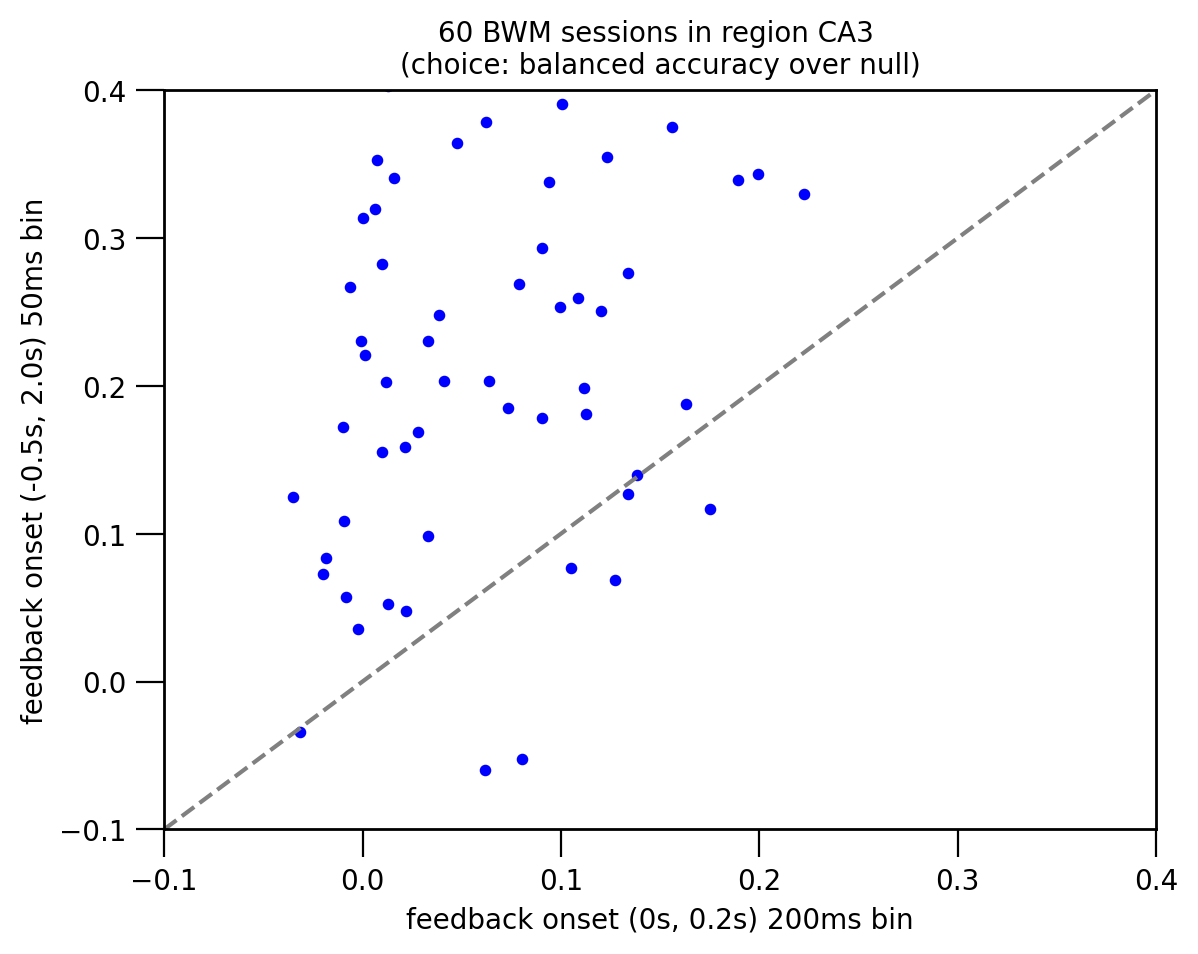

In [46]:
import matplotlib.pyplot as plt
plt.plot(figsize=(3,3))
plt.scatter(acc_bwm, acc_ours, c="blue", s=10)
plt.xlim(-0.1, 0.4)
plt.ylim(-0.1, 0.4)
plt.xlabel("feedback onset (0s, 0.2s) 200ms bin")
plt.ylabel("feedback onset (-0.5s, 2.0s) 50ms bin")
plt.plot([-0.1, 0.4], [-0.1, 0.4], ls="--", c=".5")
plt.title("60 BWM sessions in region CA3 \n(choice: balanced accuracy over null)");
# plt.savefig("./figs/bwm_choice_compare_align_time.png", dpi=200)